In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [4]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [5]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-5-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [6]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

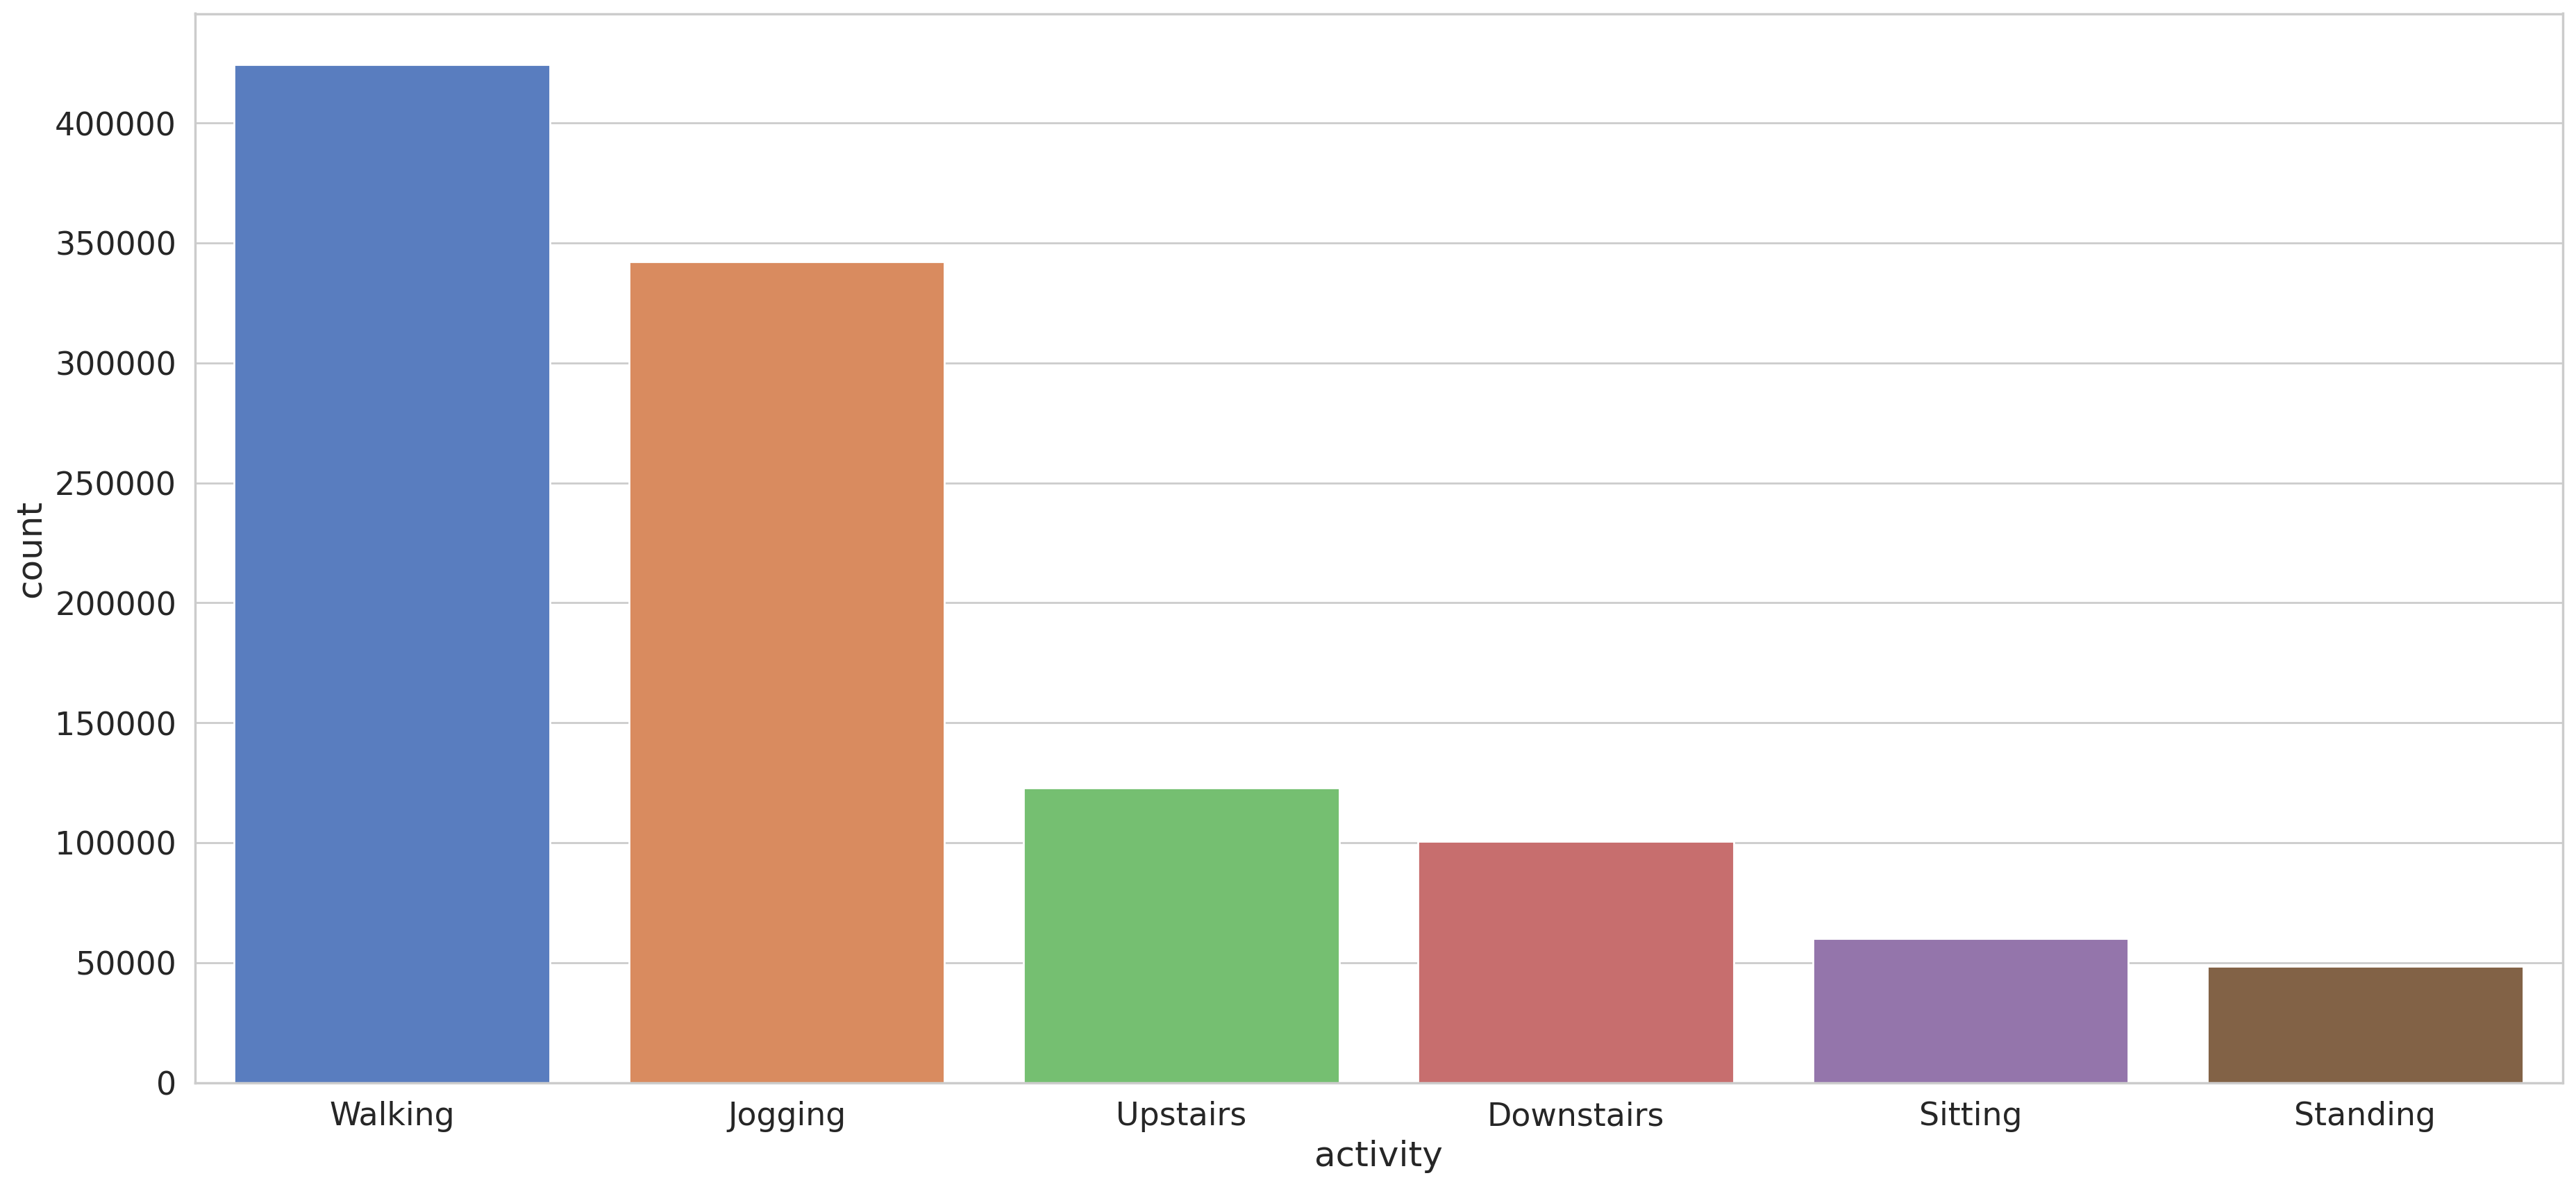

In [7]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

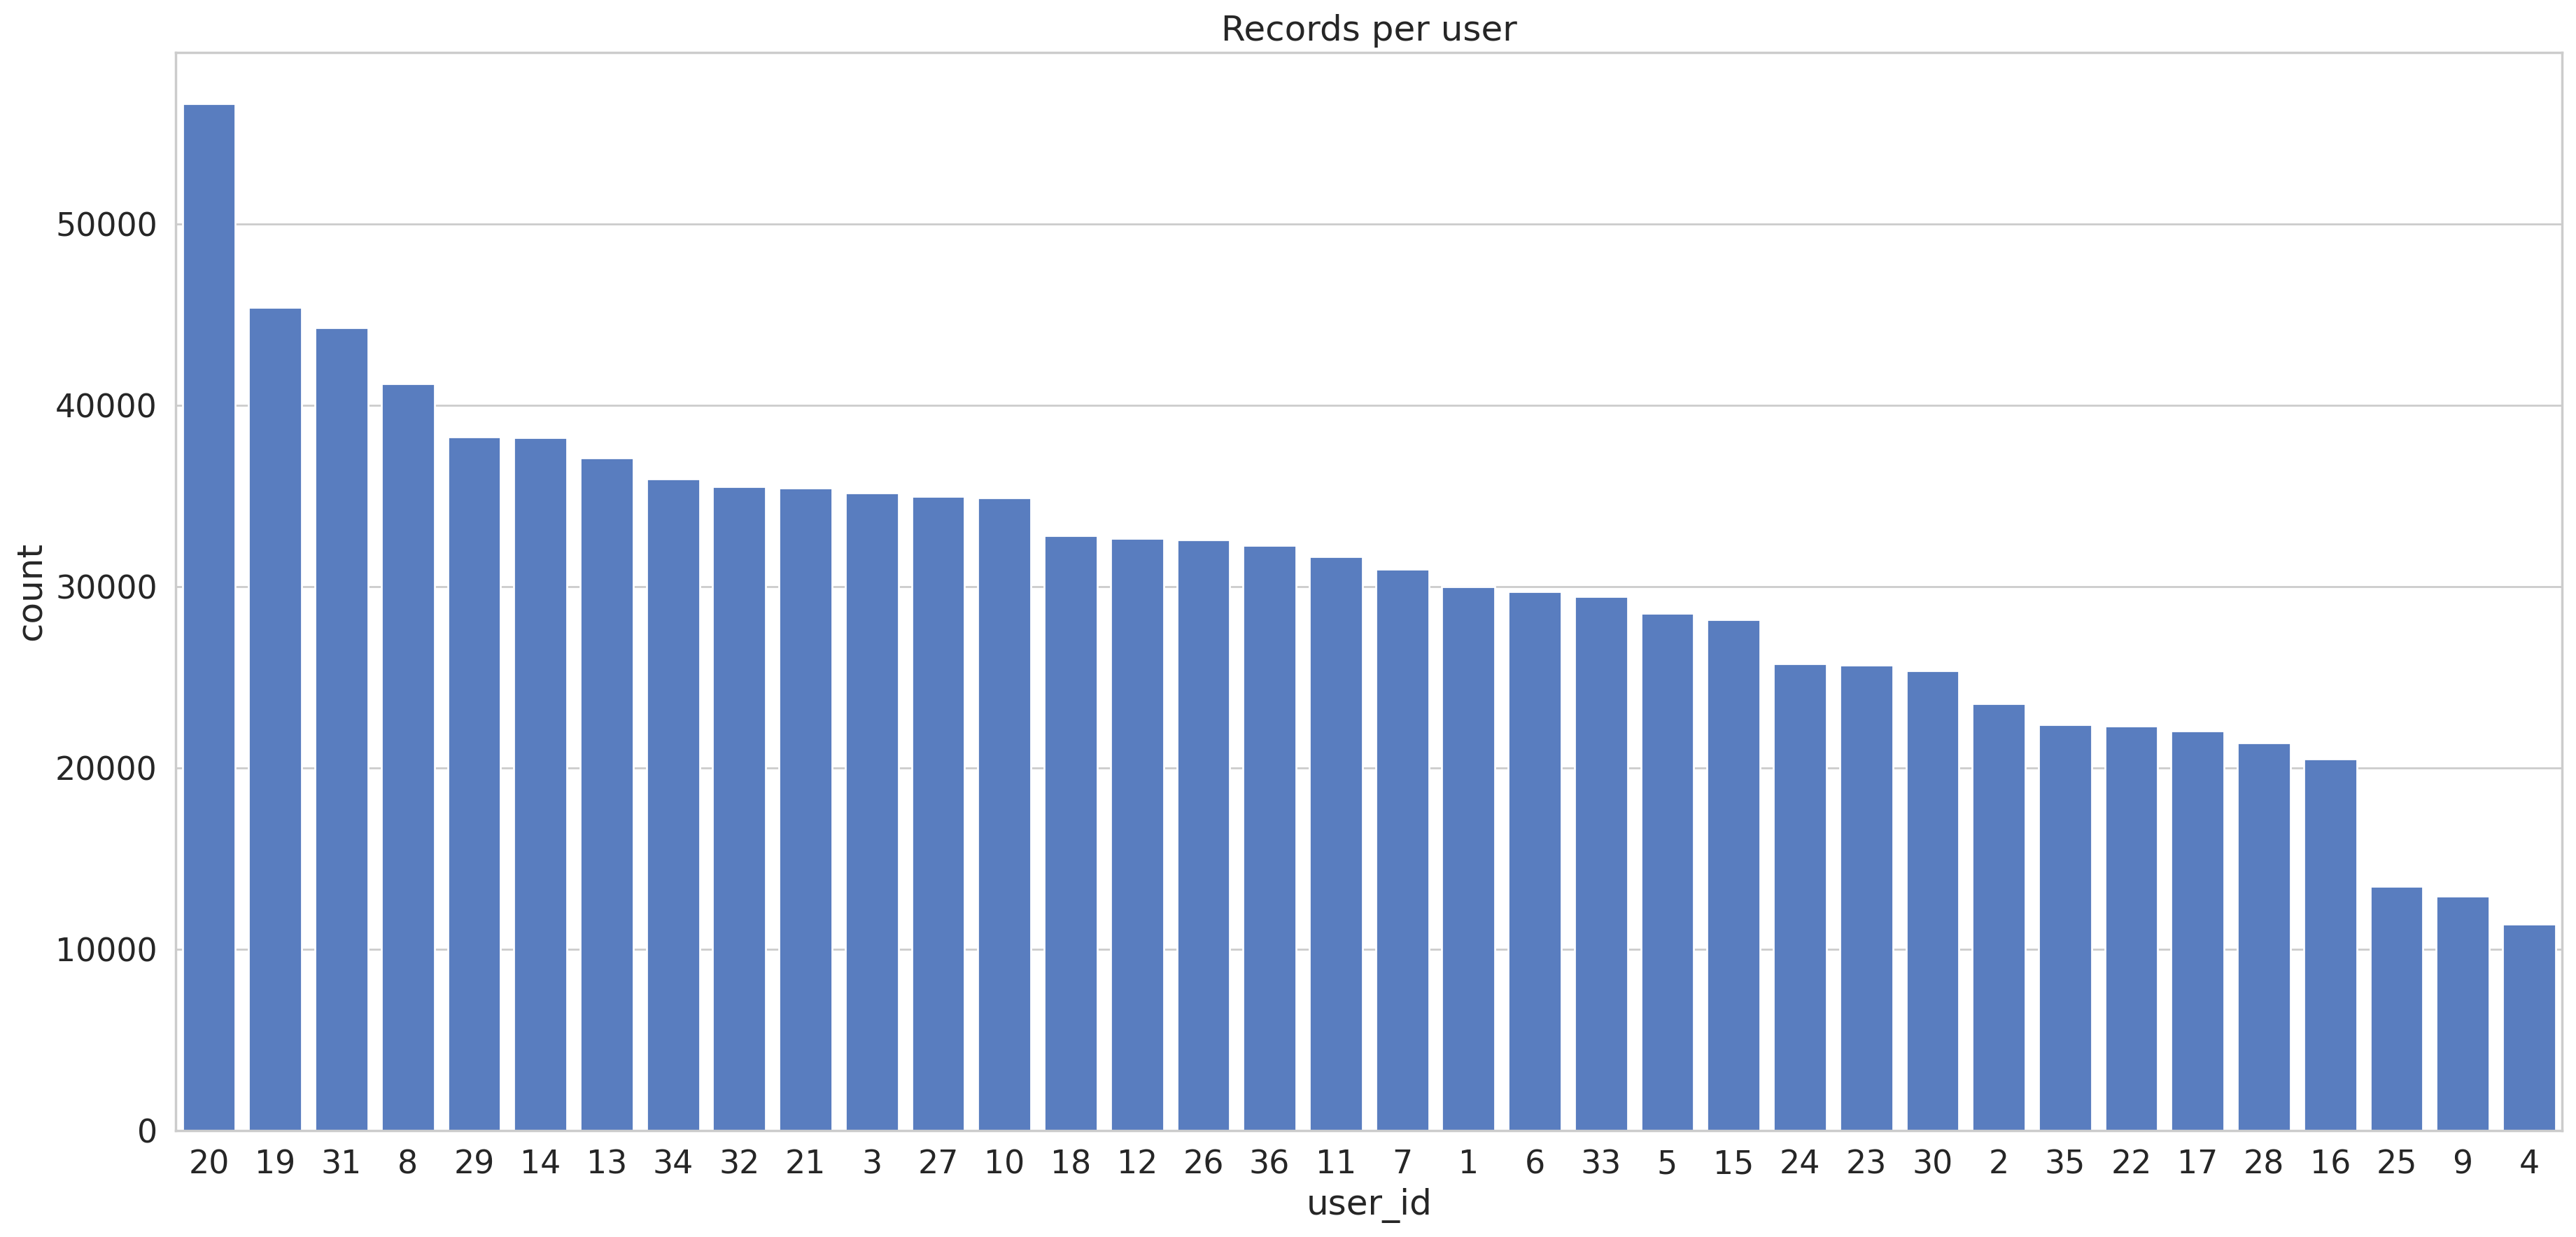

In [8]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


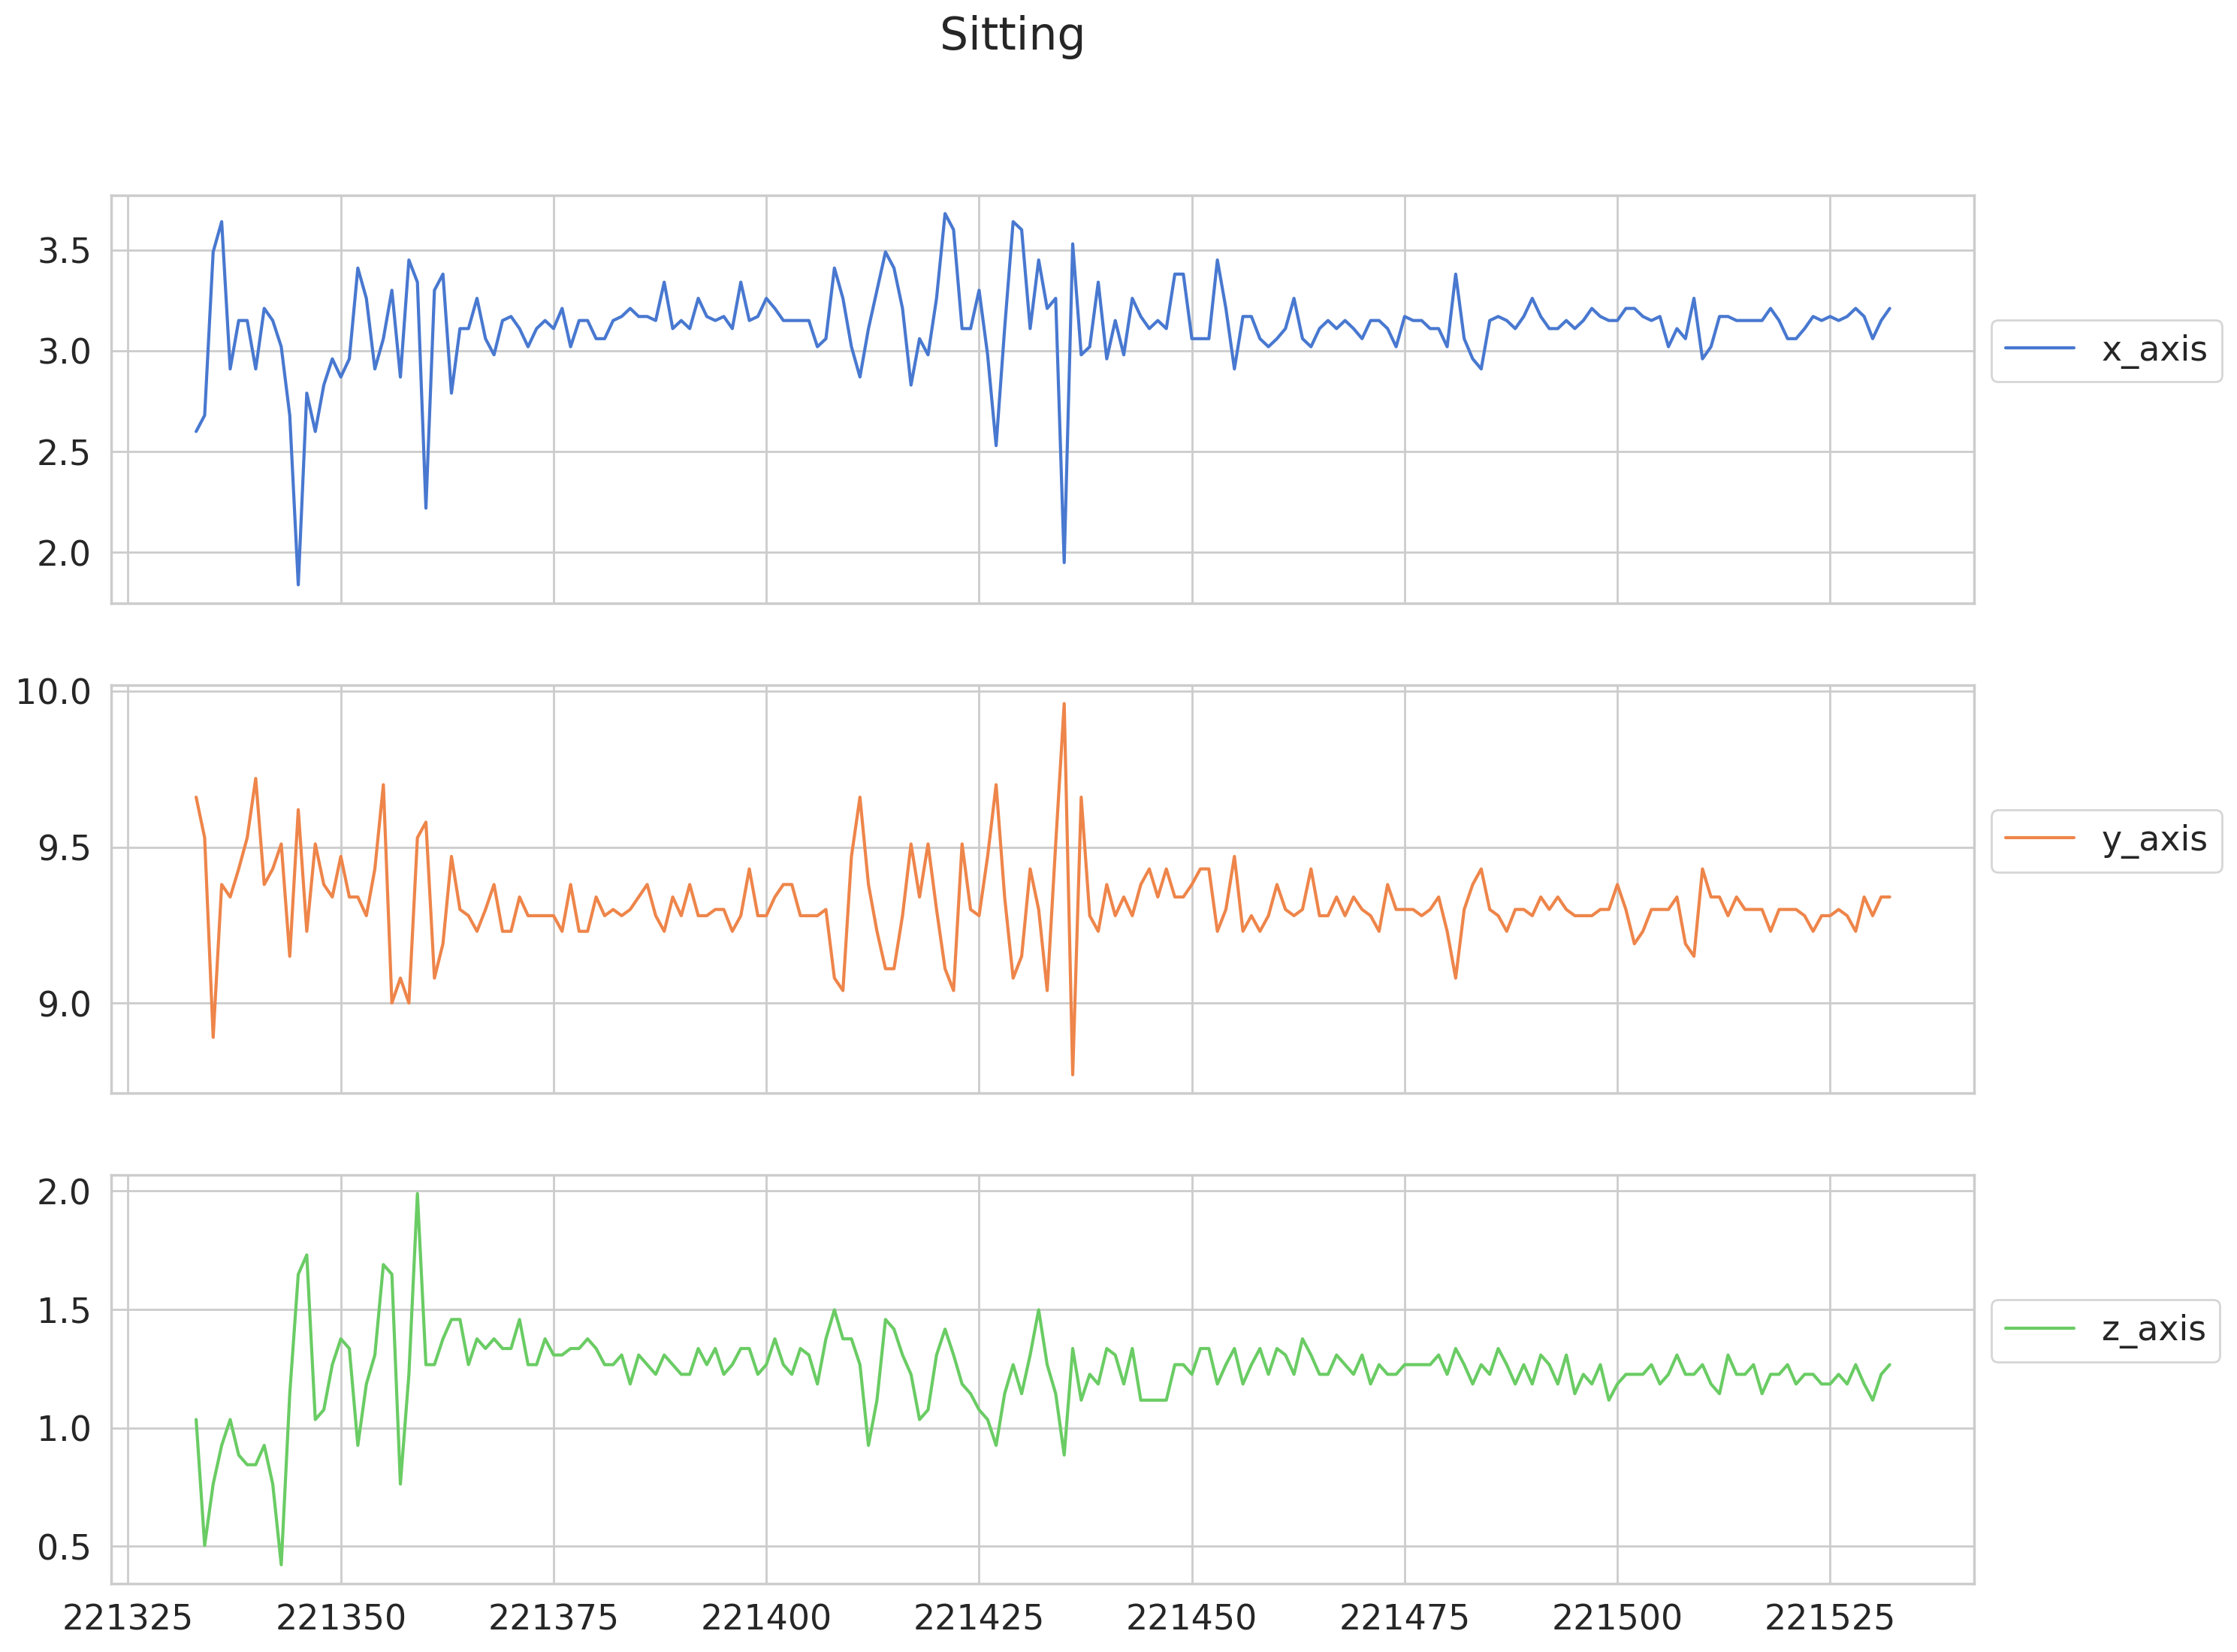

In [9]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [10]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)

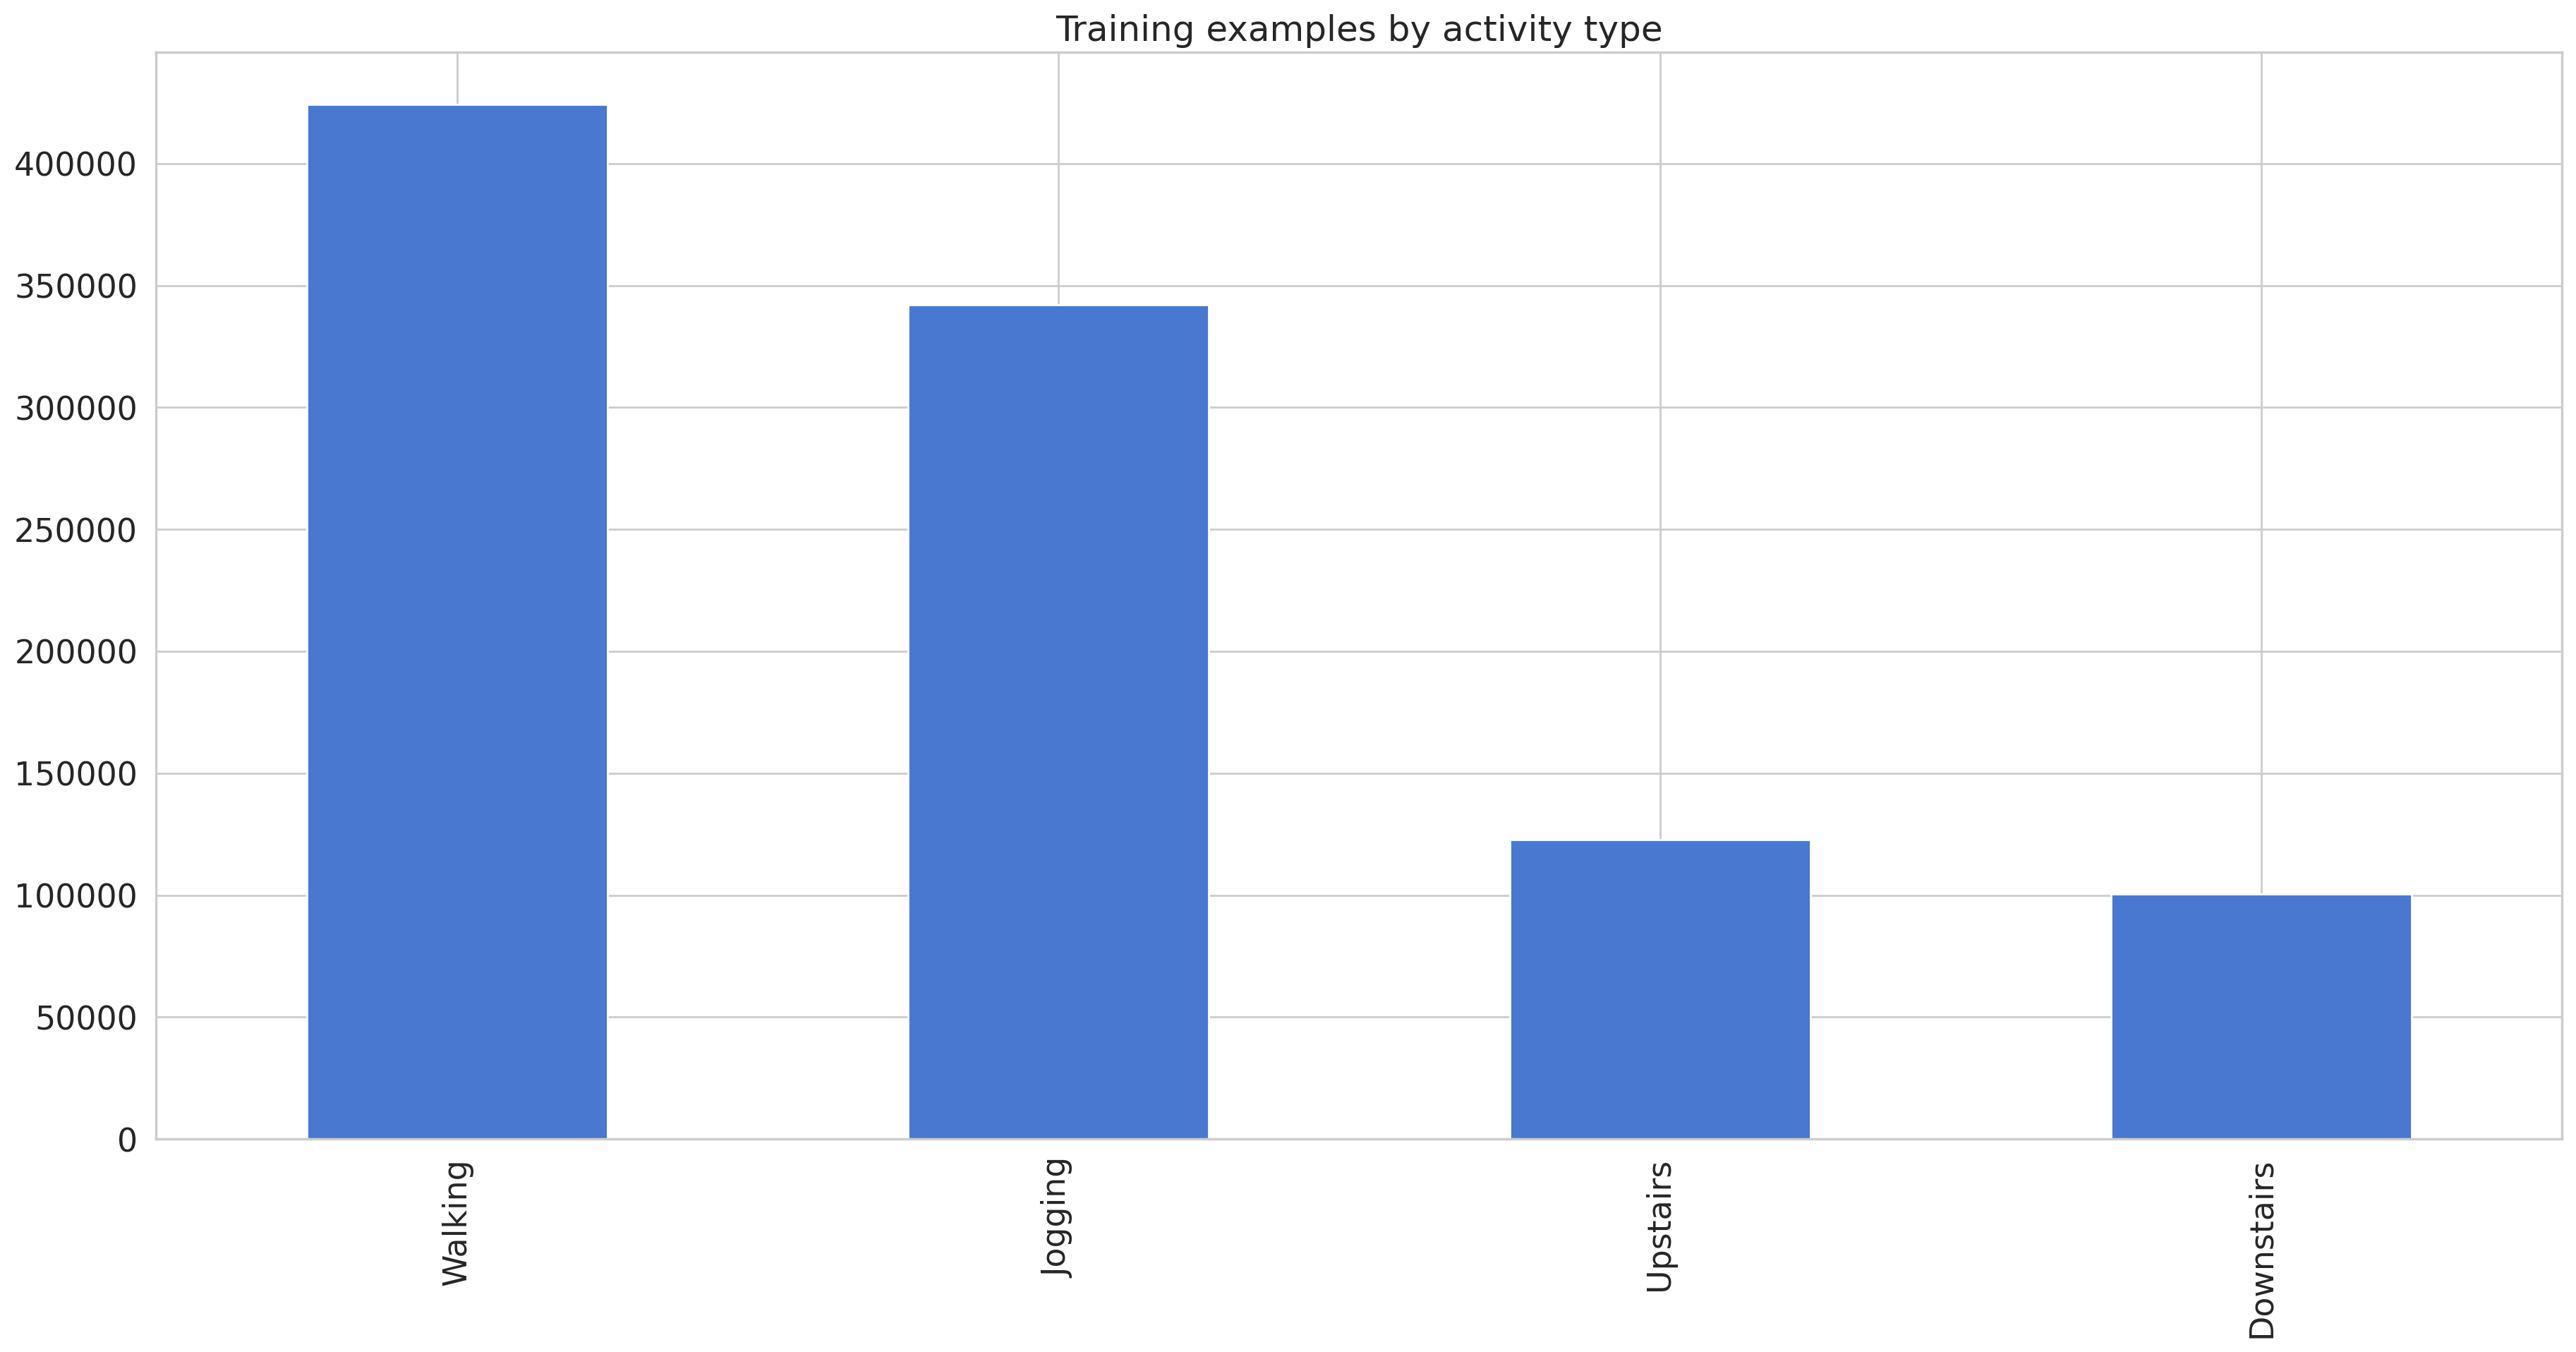

In [11]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [12]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [13]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15834, 200, 3) (15834, 1)
(4949, 200, 3) (4949, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(15834, 200, 3) (15834, 4) (4949, 200, 3) (4949, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 4)

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 128)               1622144   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1623300 (6.19 MB)
Trainable params: 1623300 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 12s 83ms/step - loss: 0.7511 - accuracy: 0.7382 - val_loss: 0.5237 - val_accuracy: 0.7997
Epoch 2/10
124/124 [==============================] - 10s 82ms/step - loss: 0.4084 - accuracy: 0.8436 - val_loss: 0.4077 - val_accuracy: 0.8388
Epoch 3/10
124/124 [==============================] - 9s 70ms/step - loss: 0.3076 - accuracy: 0.8836 - val_loss: 0.3766 - val_accuracy: 0.8591
Epoch 4/10
124/124 [==============================] - 10s 80ms/step - loss: 0.2459 - accuracy: 0.9082 - val_loss: 0.3427 - val_accuracy: 0.8777
Epoch 5/10
124/124 [==============================] - 8s 67ms/step - loss: 0.1912 - accuracy: 0.9303 - val_loss: 0.3234 - val_accuracy: 0.8805
Epoch 6/10
124/124 [==============================] - 12s 96ms/step - loss: 0.1445 - accuracy: 0.9496 - val_loss: 0.3293 - val_accuracy: 0.8914
Epoch 7/10
124/124 [==============================] - 8s 65ms/step - loss: 0.1145 - accuracy: 0.9644 - val_loss: 0.3290 - val_accuracy: 0.

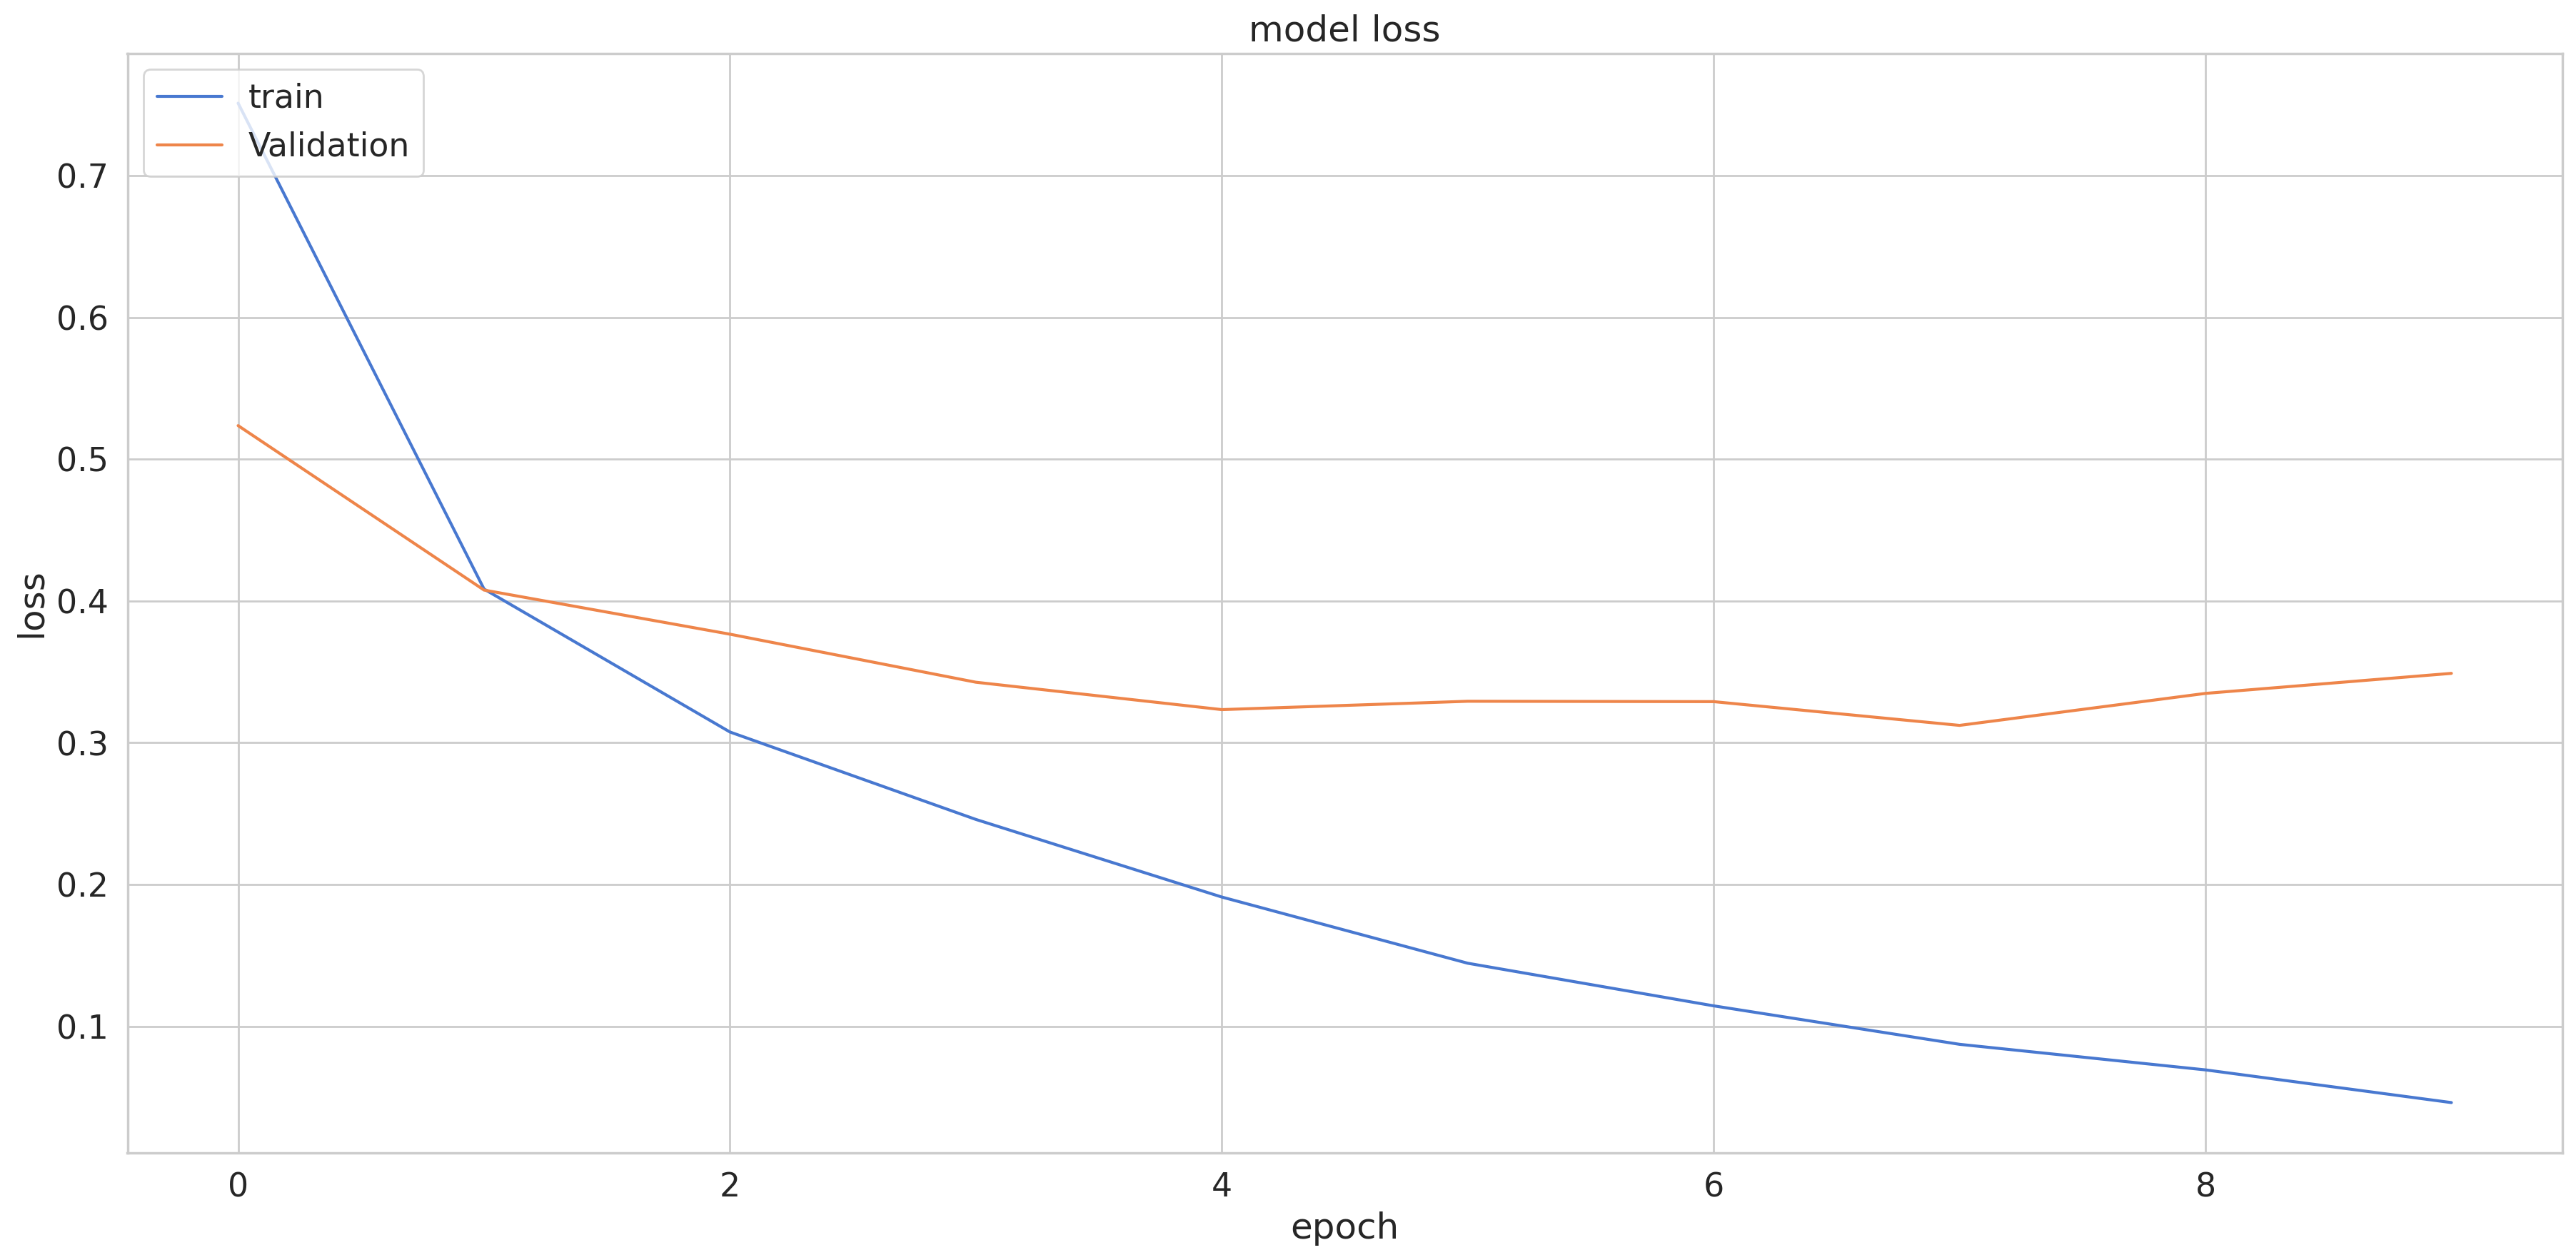

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

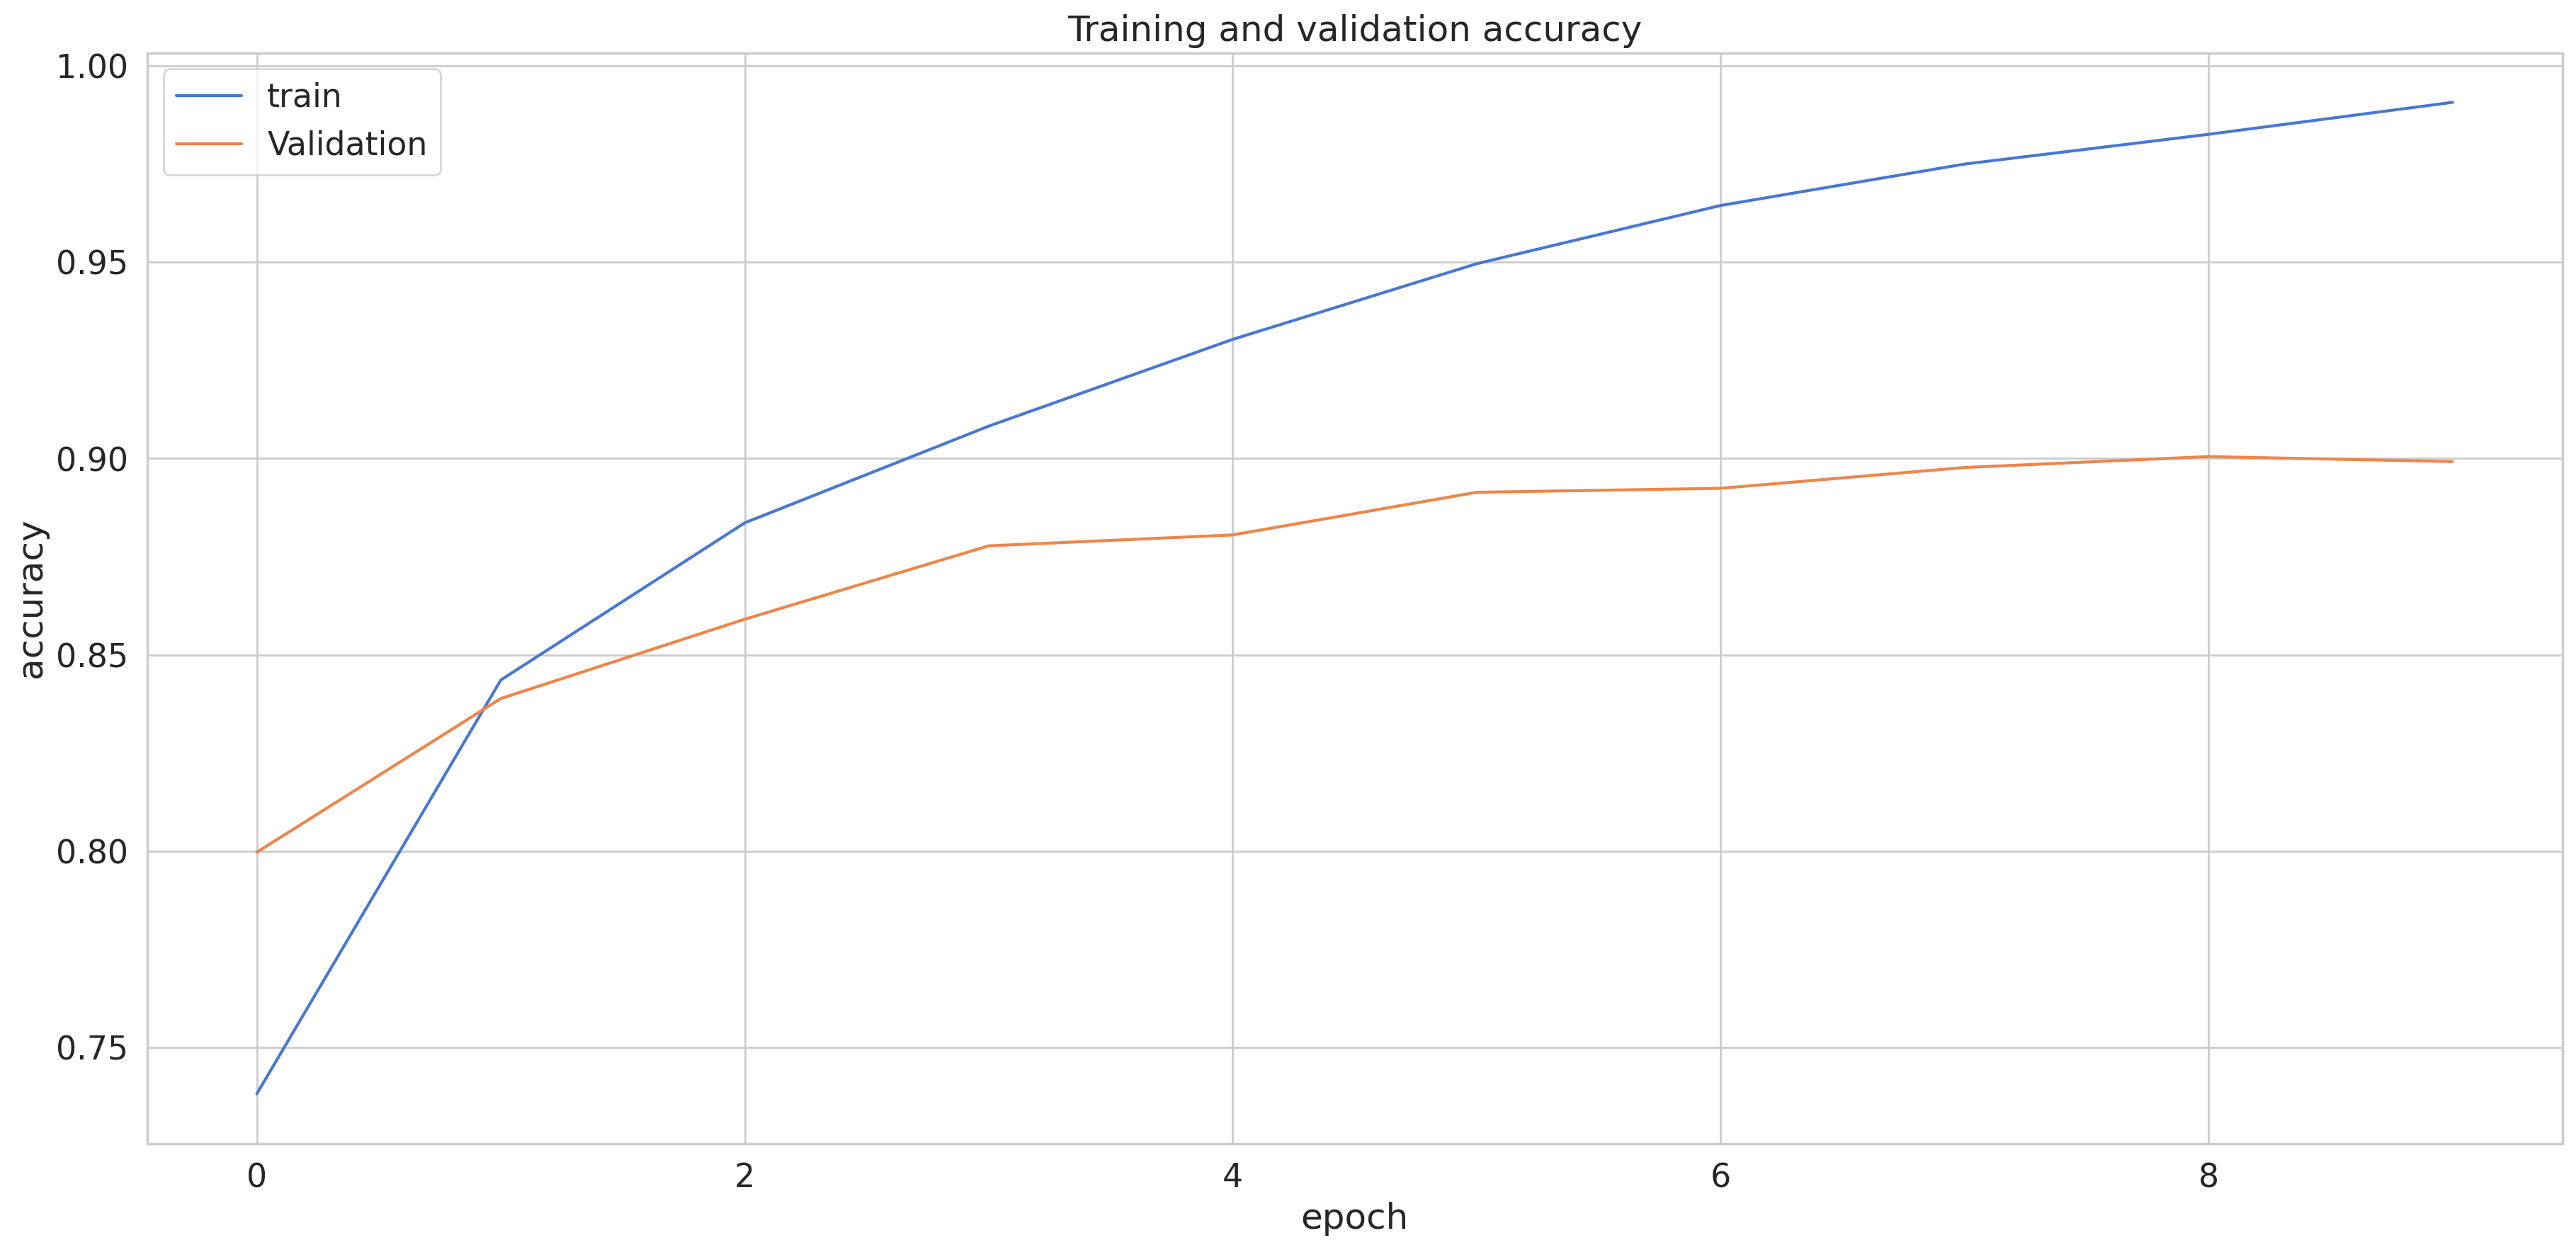

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 1s 7ms/step
f1_score =  0.9031750628209766
0.9060416245706203
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2123
           1       0.95      0.98      0.97      1710
           2       0.82      0.63      0.71       615
           3       0.70      0.73      0.71       501

    accuracy                           0.91      4949
   macro avg       0.85      0.83      0.84      4949
weighted avg       0.90      0.91      0.90      4949



<Axes: >

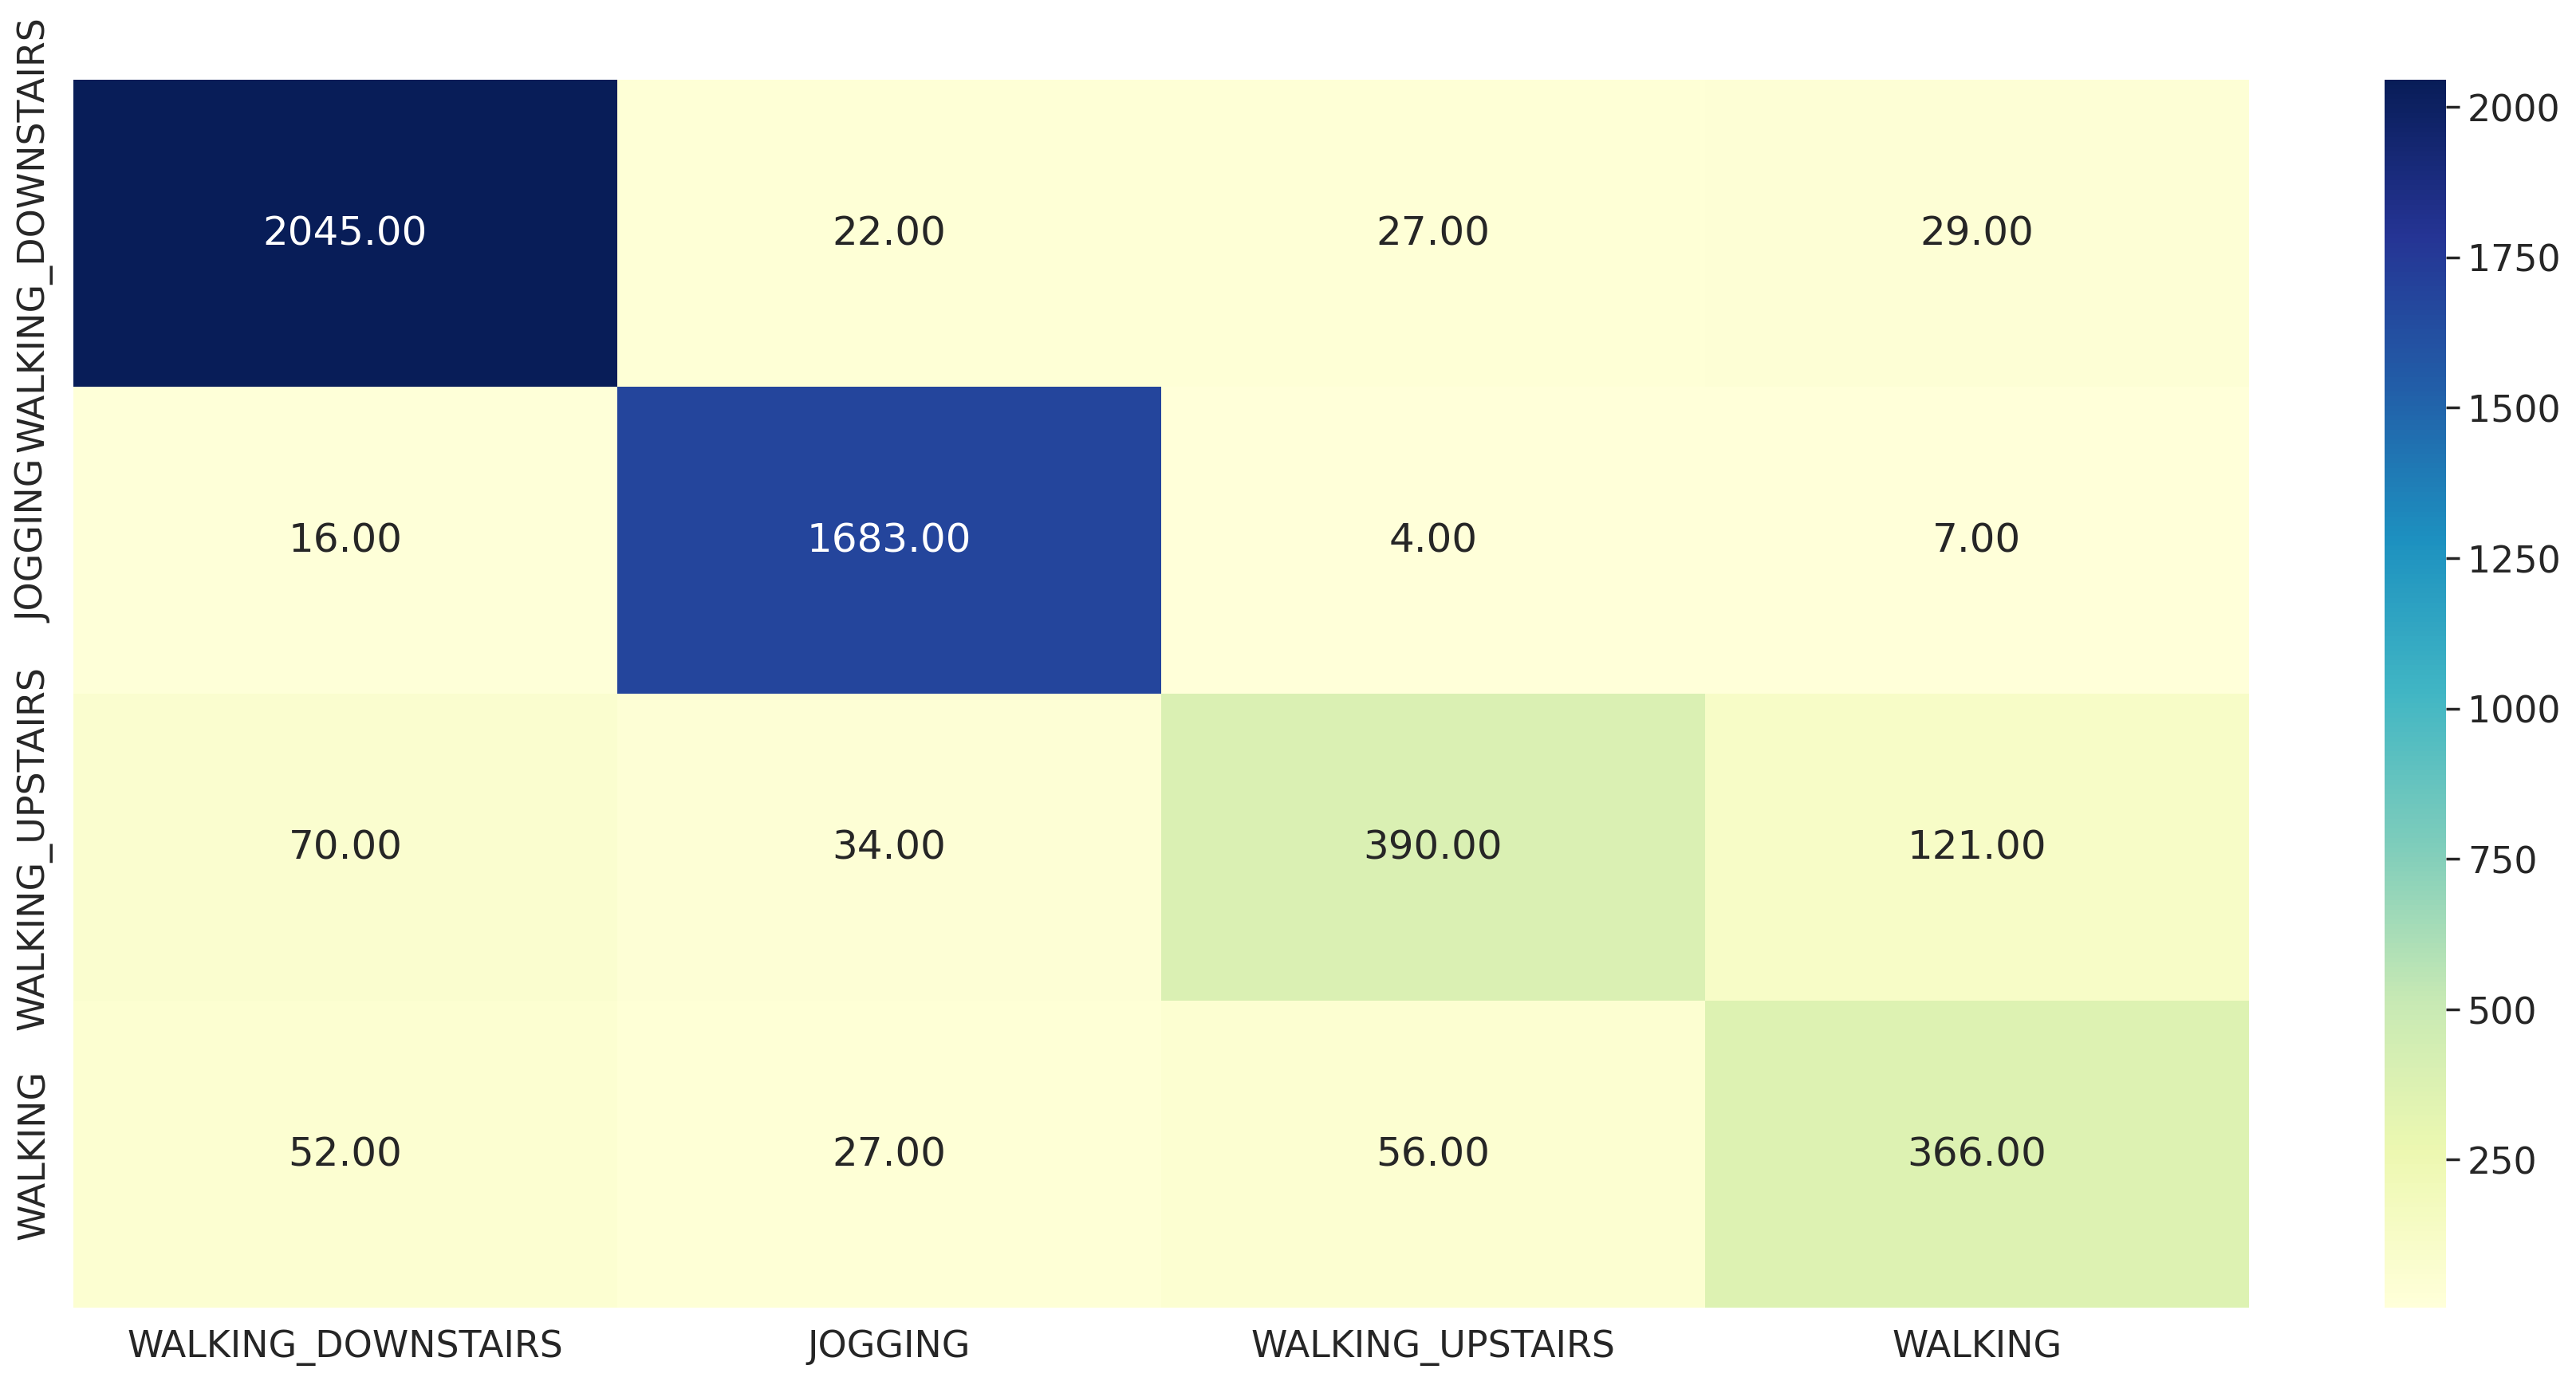

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1619268 (6.18 MB)
Trainable params: 1619268 (6.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 18s 120ms/step - loss: 0.6937 - accuracy: 0.7387 - val_loss: 0.4431 - val_accuracy: 0.8128
Epoch 2/10
124/124 [==============================] - 15s 120ms/step - loss: 0.3242 - accuracy: 0.8744 - val_loss: 0.2639 - val_accuracy: 0.8977
Epoch 3/10
124/124 [==============================] - 17s 134ms/step - loss: 0.1706 - accuracy: 0.9433 - val_loss: 0.2005 - val_accuracy: 0.9265
Epoch 4/10
124/124 [==============================] - 15s 124ms/step - loss: 0.0990 - accuracy: 0.9705 - val_loss: 0.2063 - val_accuracy: 0.9232
Epoch 5/10
124/124 [==============================] - 15s 120ms/step - loss: 0.0577 - accuracy: 0.9845 - val_loss: 0.1905 - val_accuracy: 0.9341
Epoch 6/10
124/124 [==============================] - 15s 121ms/step - loss: 0.0394 - accuracy: 0.9903 - val_loss: 0.1502 - val_accuracy: 0.9485
Epoch 7/10
124/124 [==============================] - 25s 202ms/step - loss: 0.0148 - accuracy: 0.9982 - val_loss: 0.1564 - val_ac

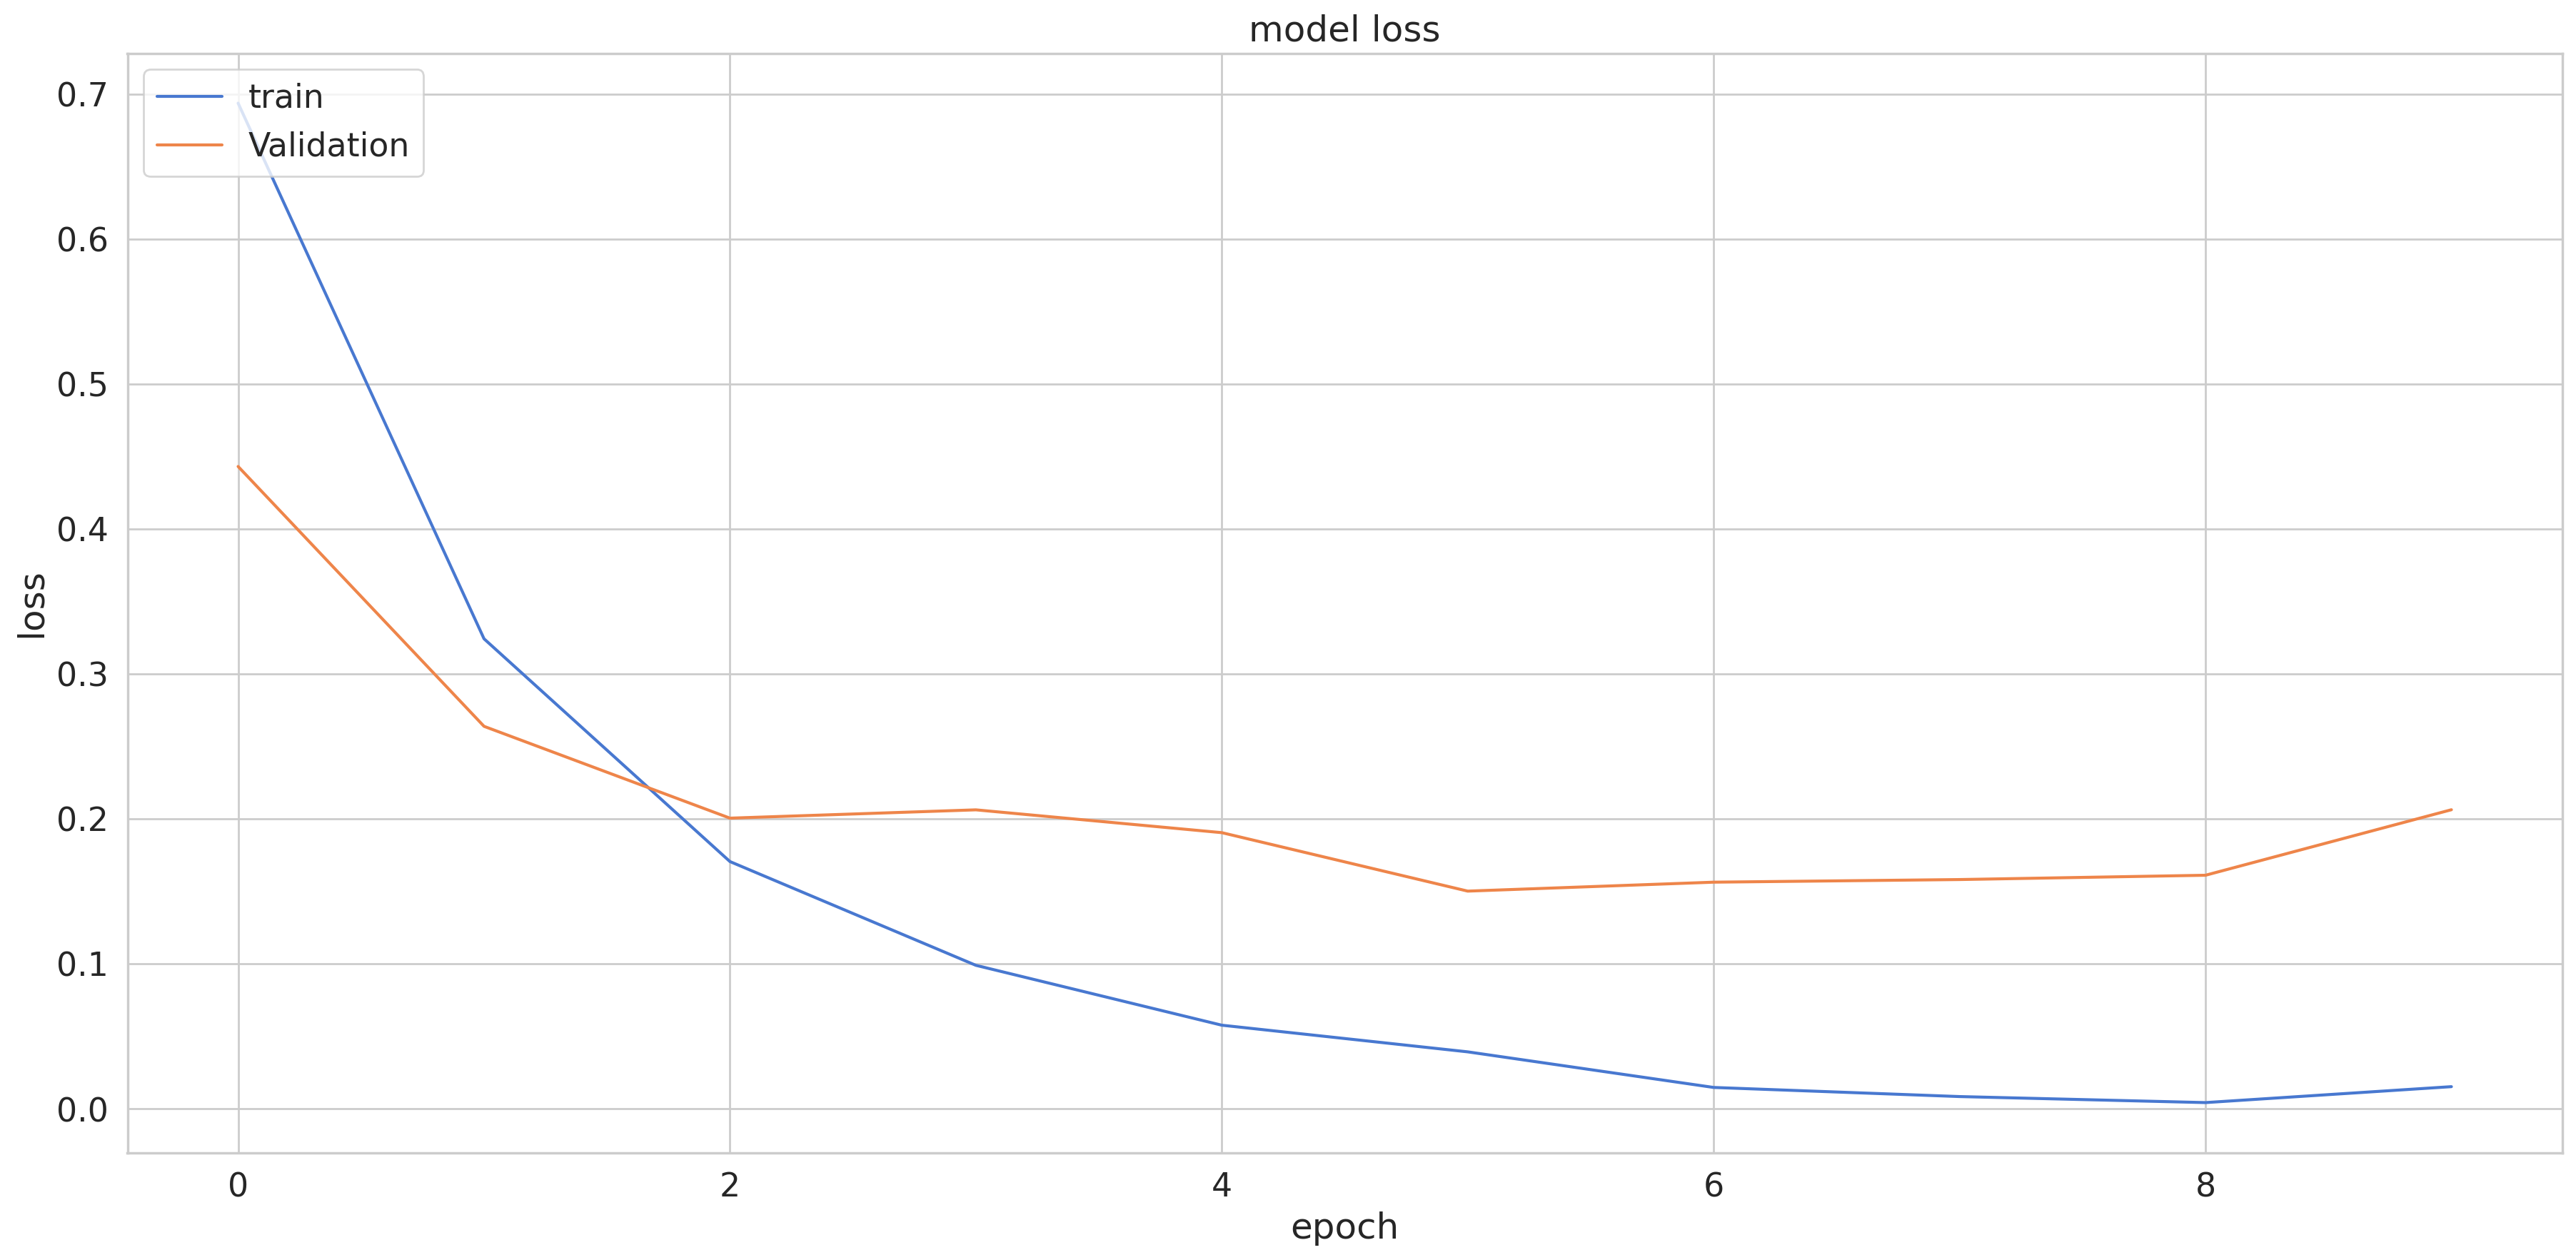

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

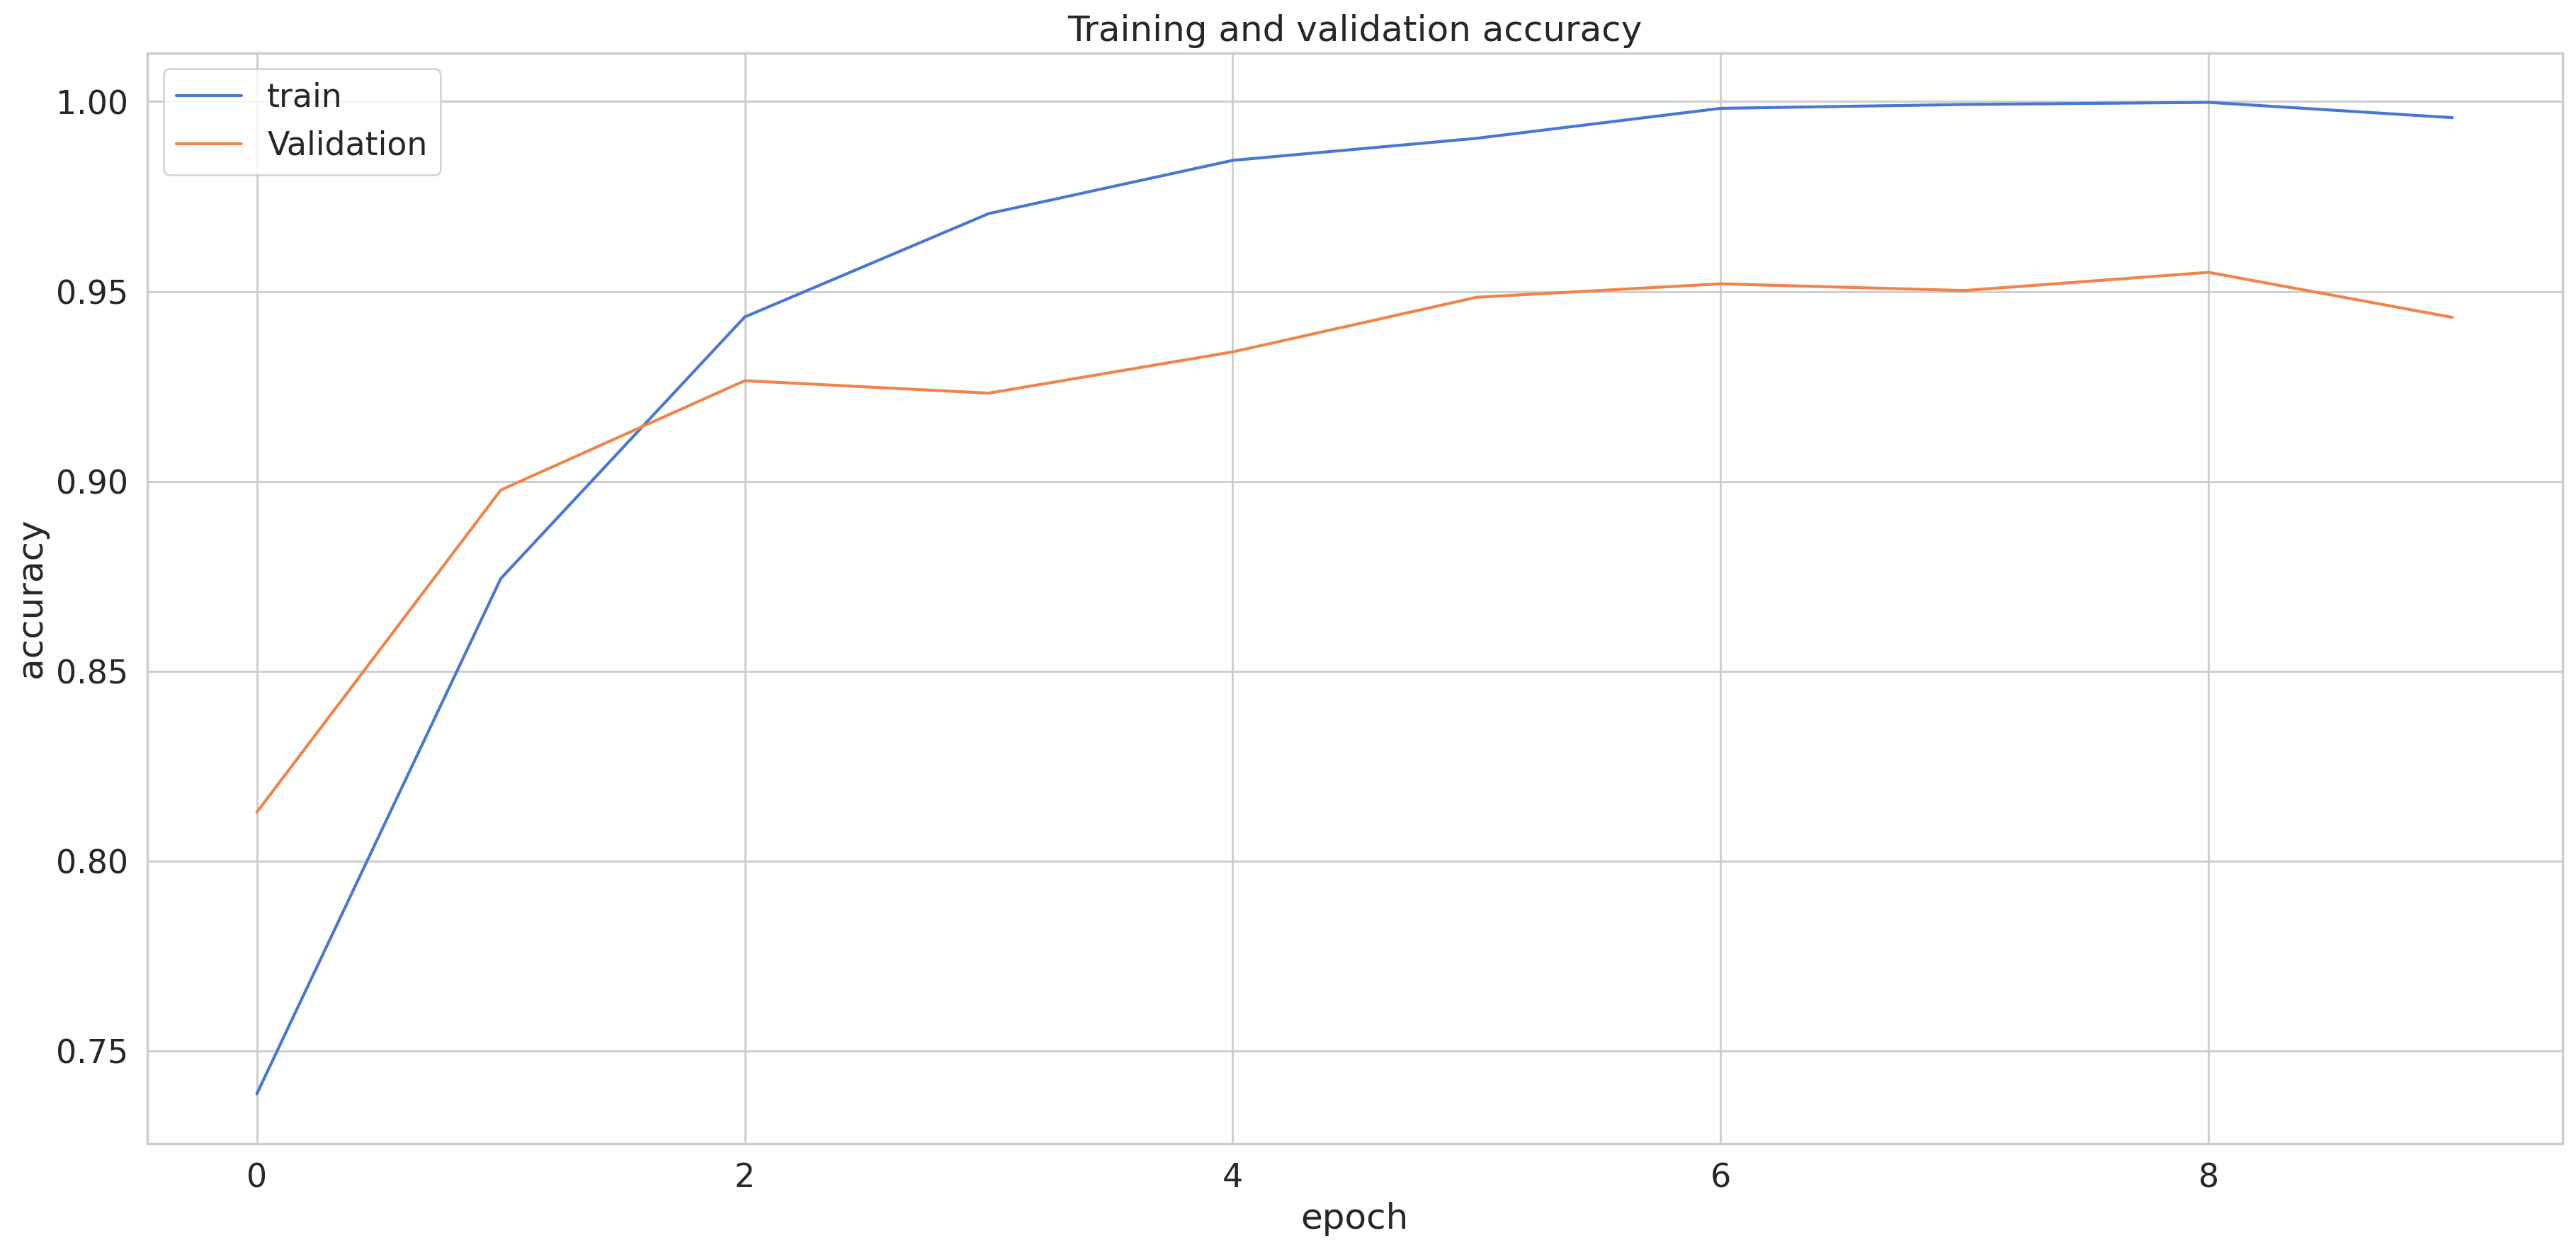

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 10ms/step
f1_score =  0.9485955261206594
0.9492826833703778
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2123
           1       0.97      0.99      0.98      1710
           2       0.82      0.92      0.87       615
           3       0.92      0.74      0.82       501

    accuracy                           0.95      4949
   macro avg       0.92      0.91      0.91      4949
weighted avg       0.95      0.95      0.95      4949



<Axes: >

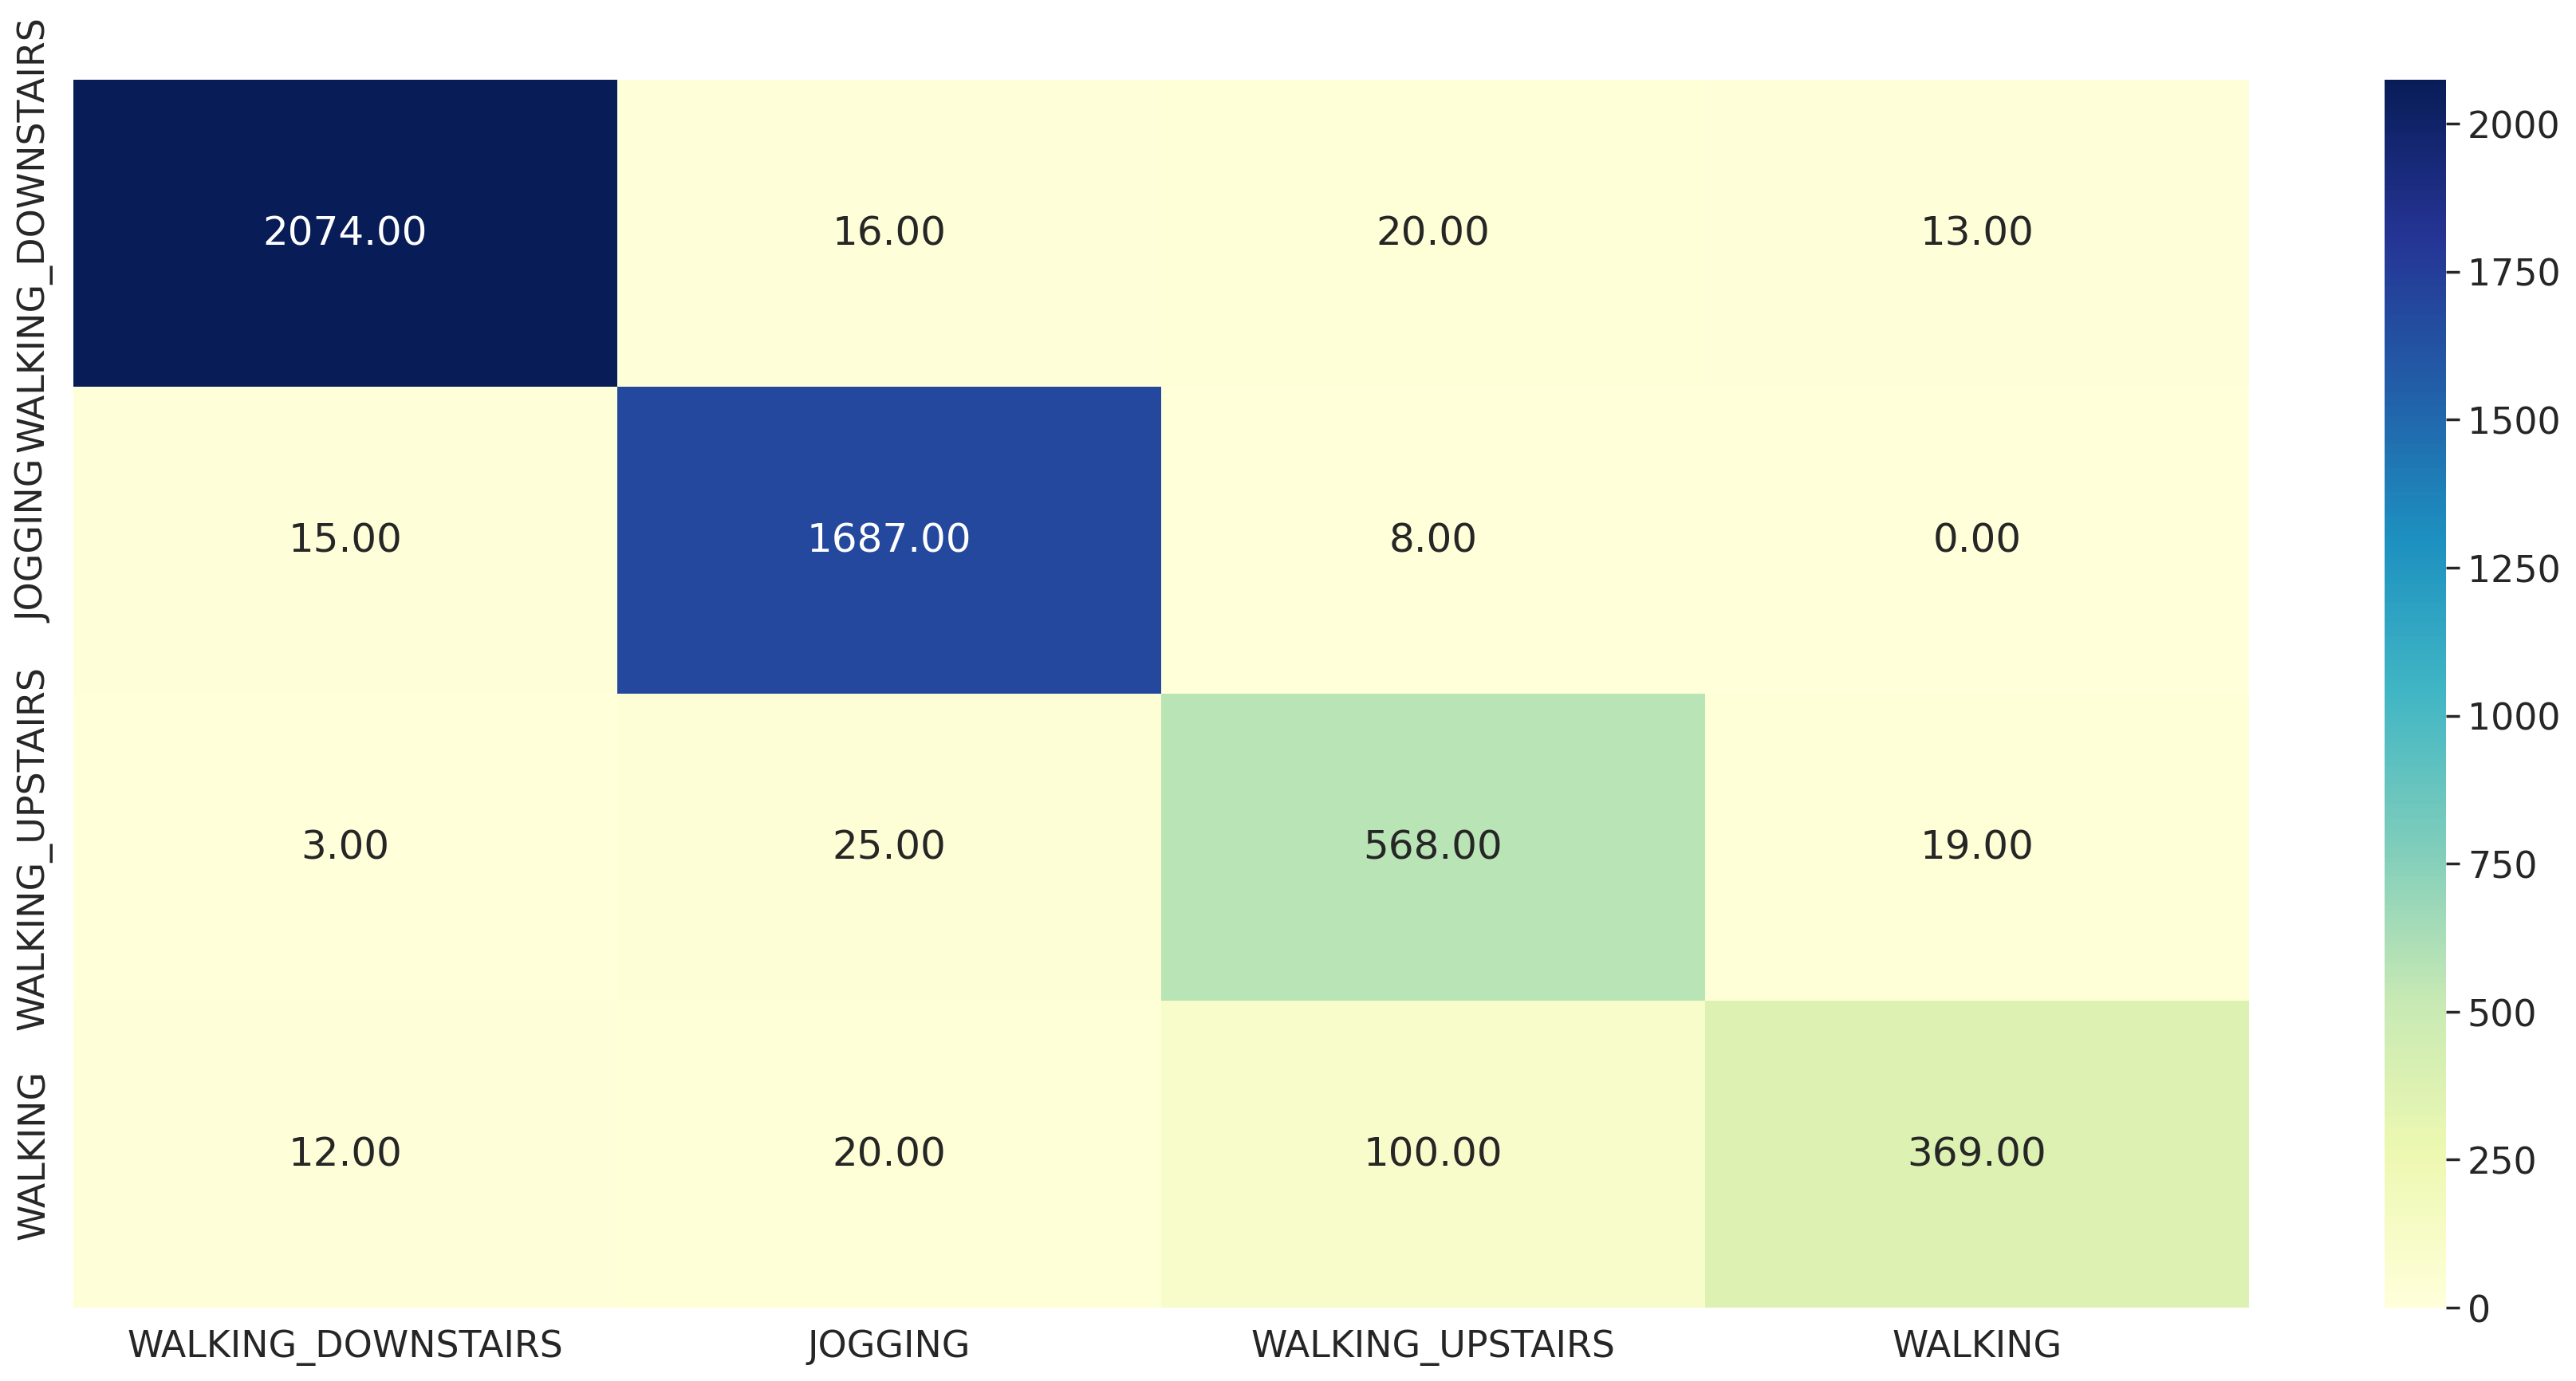

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_5 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_6 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 97, 64)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 6208)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               794752    
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 32s 248ms/step - loss: 0.5794 - accuracy: 0.7775 - val_loss: 0.3359 - val_accuracy: 0.8563
Epoch 2/10
124/124 [==============================] - 27s 215ms/step - loss: 0.2344 - accuracy: 0.9111 - val_loss: 0.1917 - val_accuracy: 0.9267
Epoch 3/10
124/124 [==============================] - 21s 173ms/step - loss: 0.1448 - accuracy: 0.9499 - val_loss: 0.1761 - val_accuracy: 0.9275
Epoch 4/10
124/124 [==============================] - 19s 152ms/step - loss: 0.0941 - accuracy: 0.9692 - val_loss: 0.1179 - val_accuracy: 0.9560
Epoch 5/10
124/124 [==============================] - 19s 154ms/step - loss: 0.0630 - accuracy: 0.9793 - val_loss: 0.1218 - val_accuracy: 0.9548
Epoch 6/10
124/124 [==============================] - 21s 173ms/step - loss: 0.0500 - accuracy: 0.9831 - val_loss: 0.1639 - val_accuracy: 0.9457
Epoch 7/10
124/124 [==============================] - 19s 152ms/step - loss: 0.0293 - accuracy: 0.9917 - val_loss: 0.0960 - val_ac

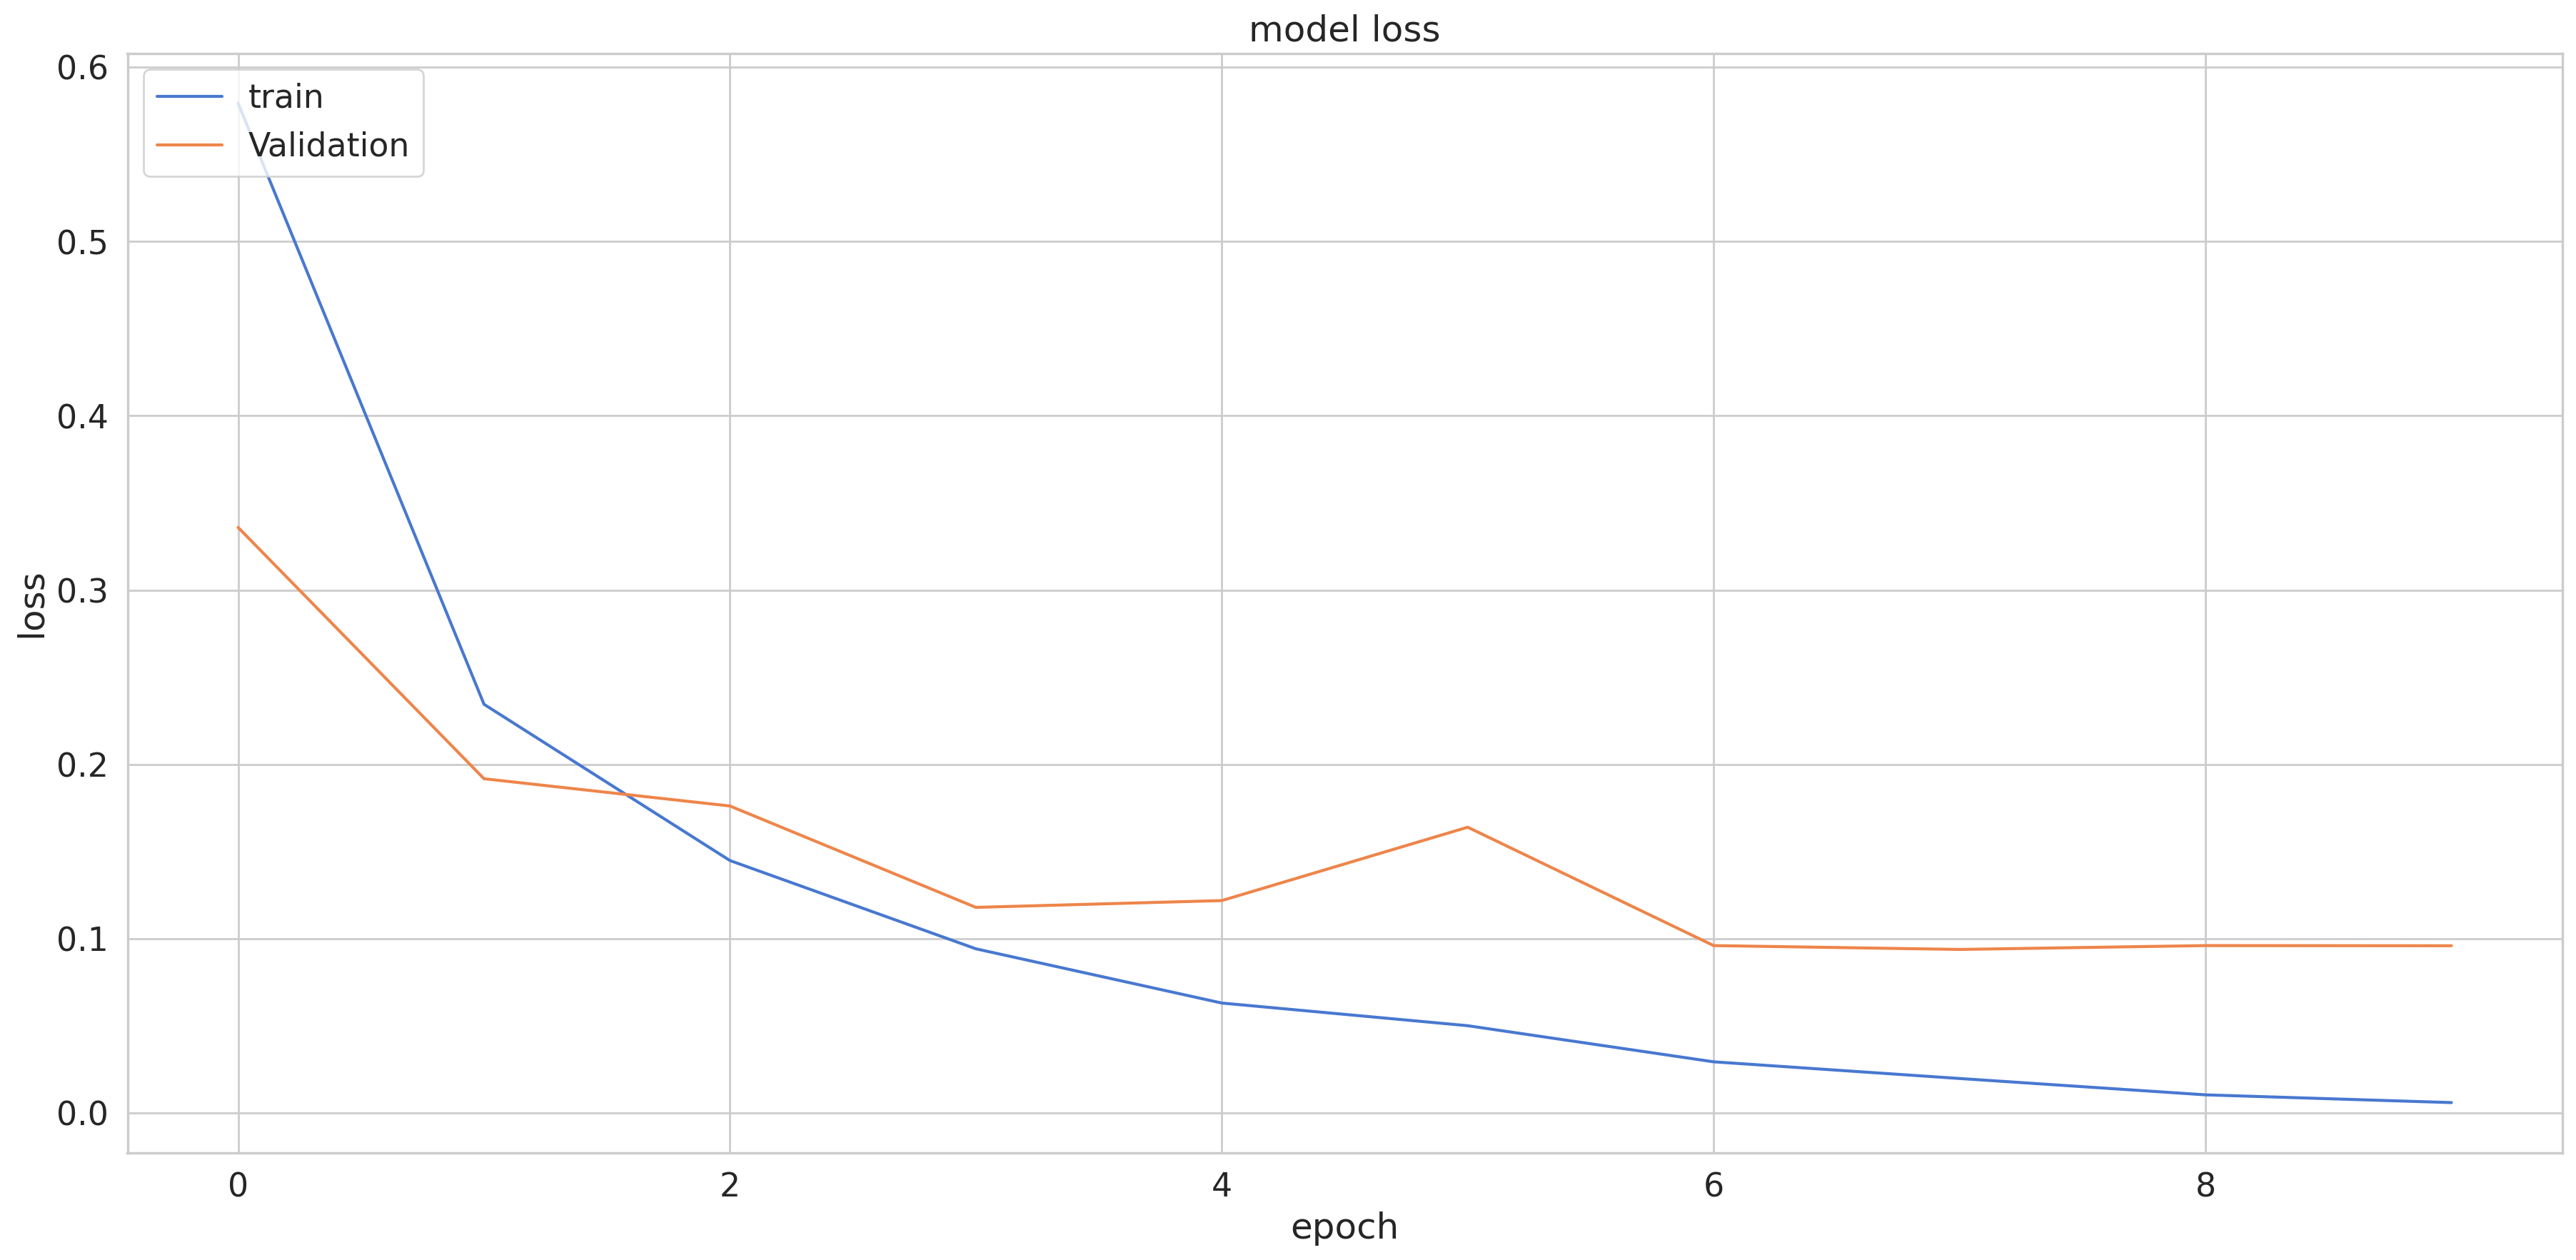

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

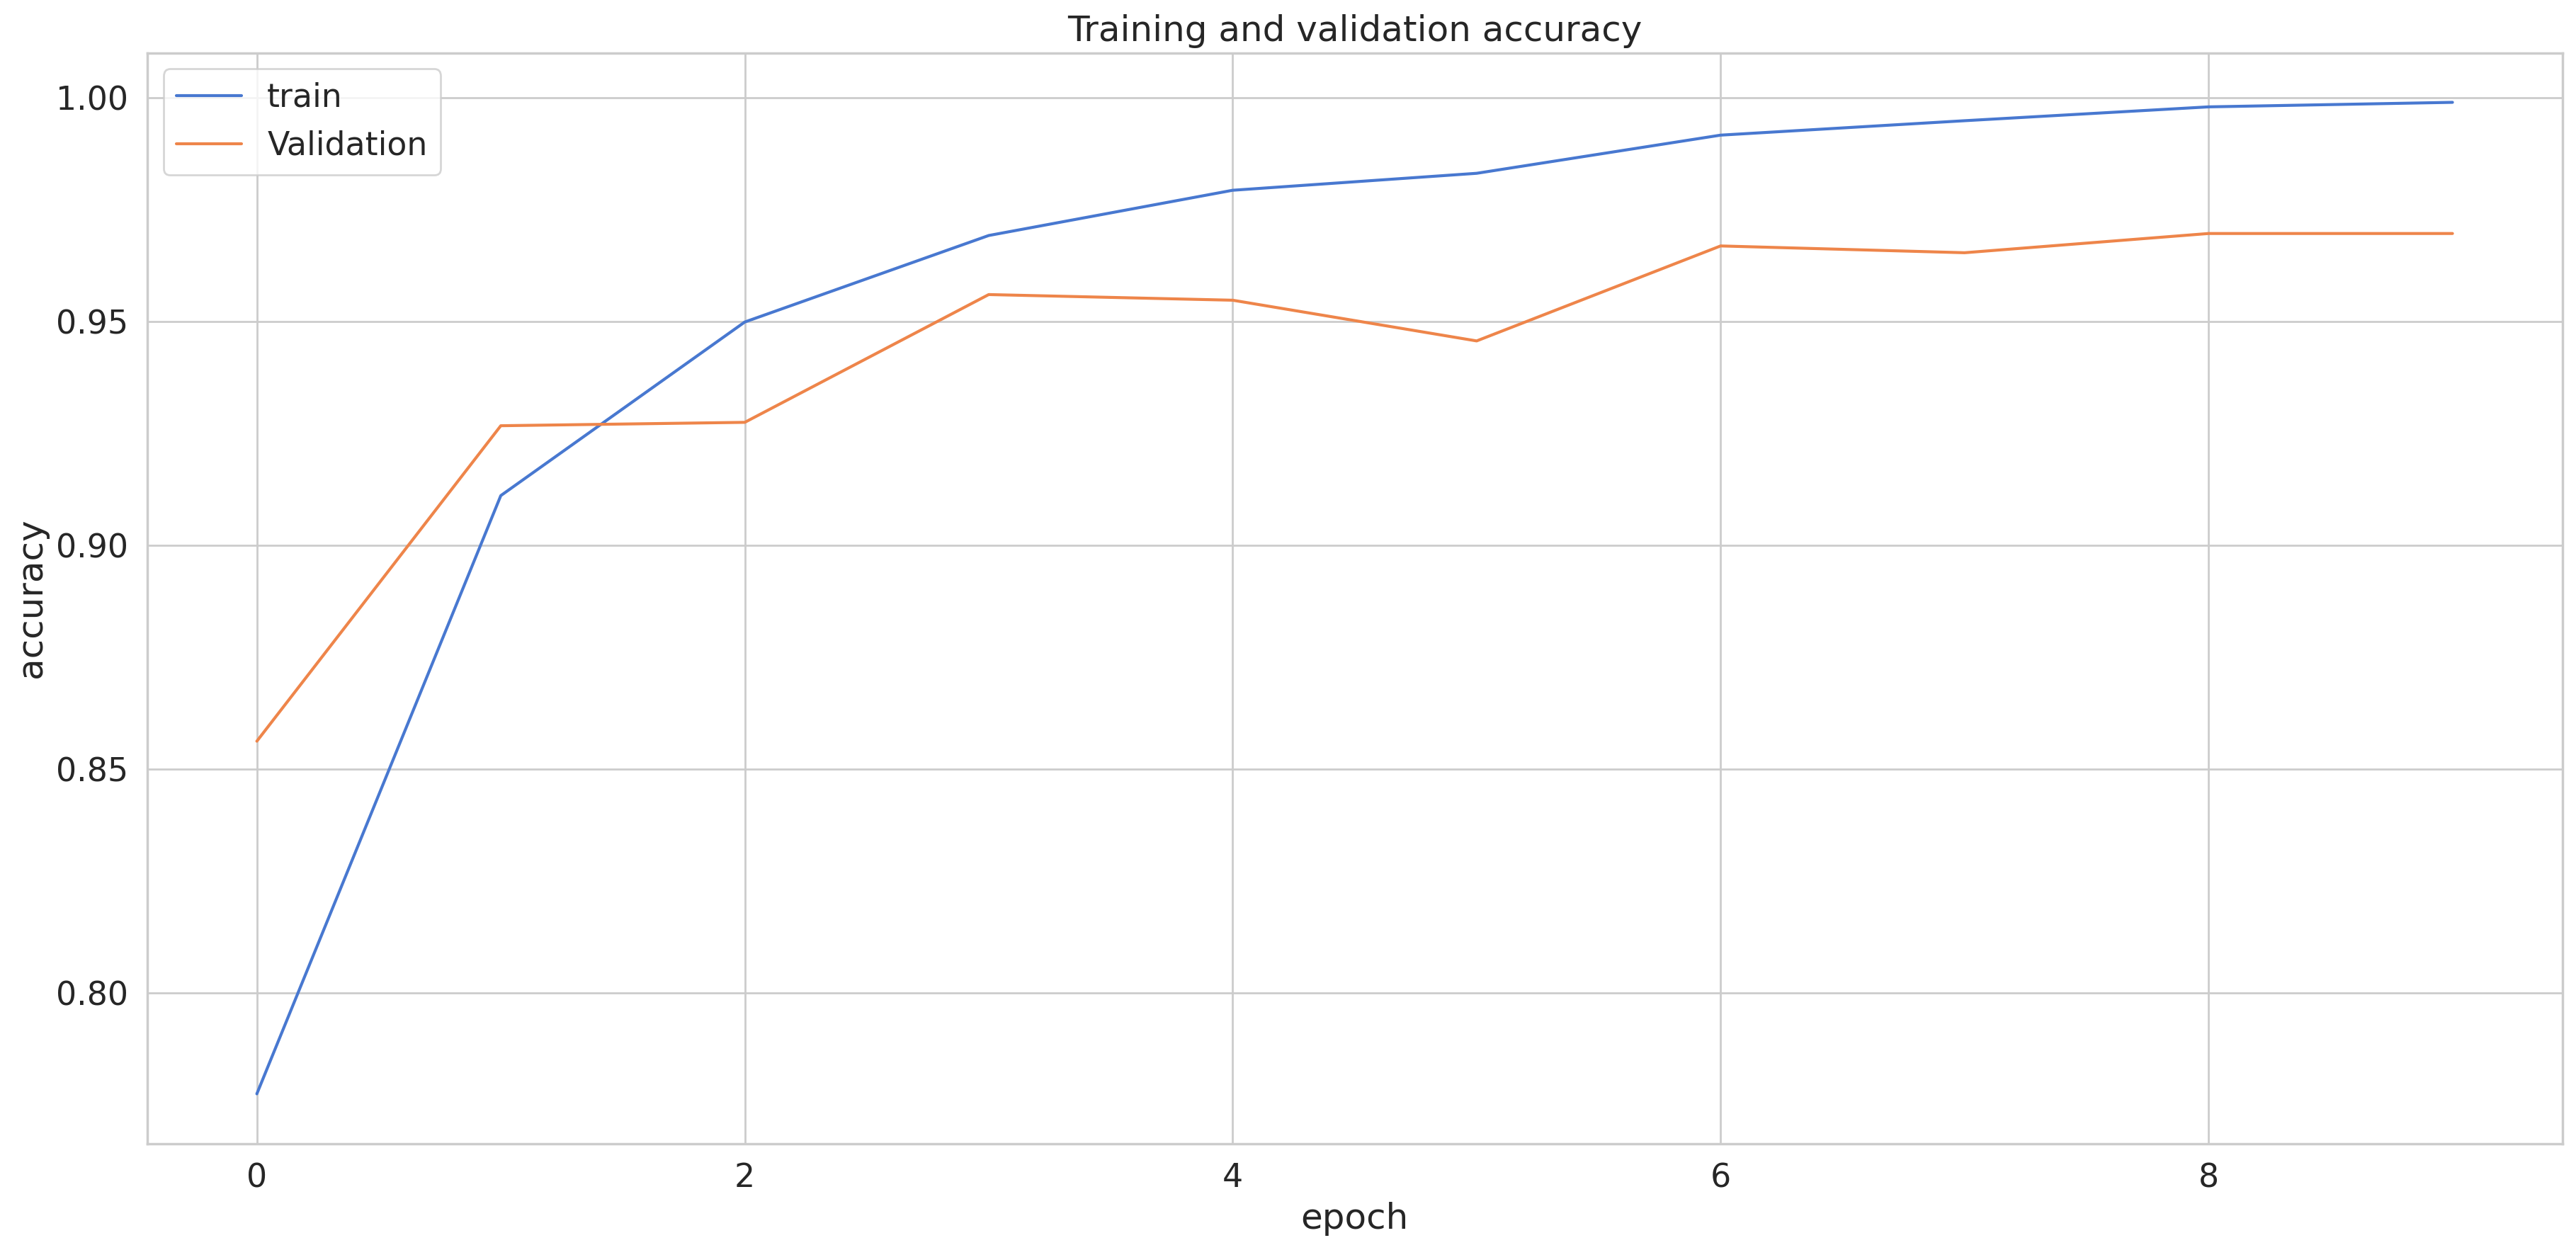

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 11ms/step
f1_score =  0.9756841143952805
0.9757526773085472
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.92      0.93      0.93       615
           3       0.94      0.91      0.92       501

    accuracy                           0.98      4949
   macro avg       0.96      0.96      0.96      4949
weighted avg       0.98      0.98      0.98      4949



<Axes: >

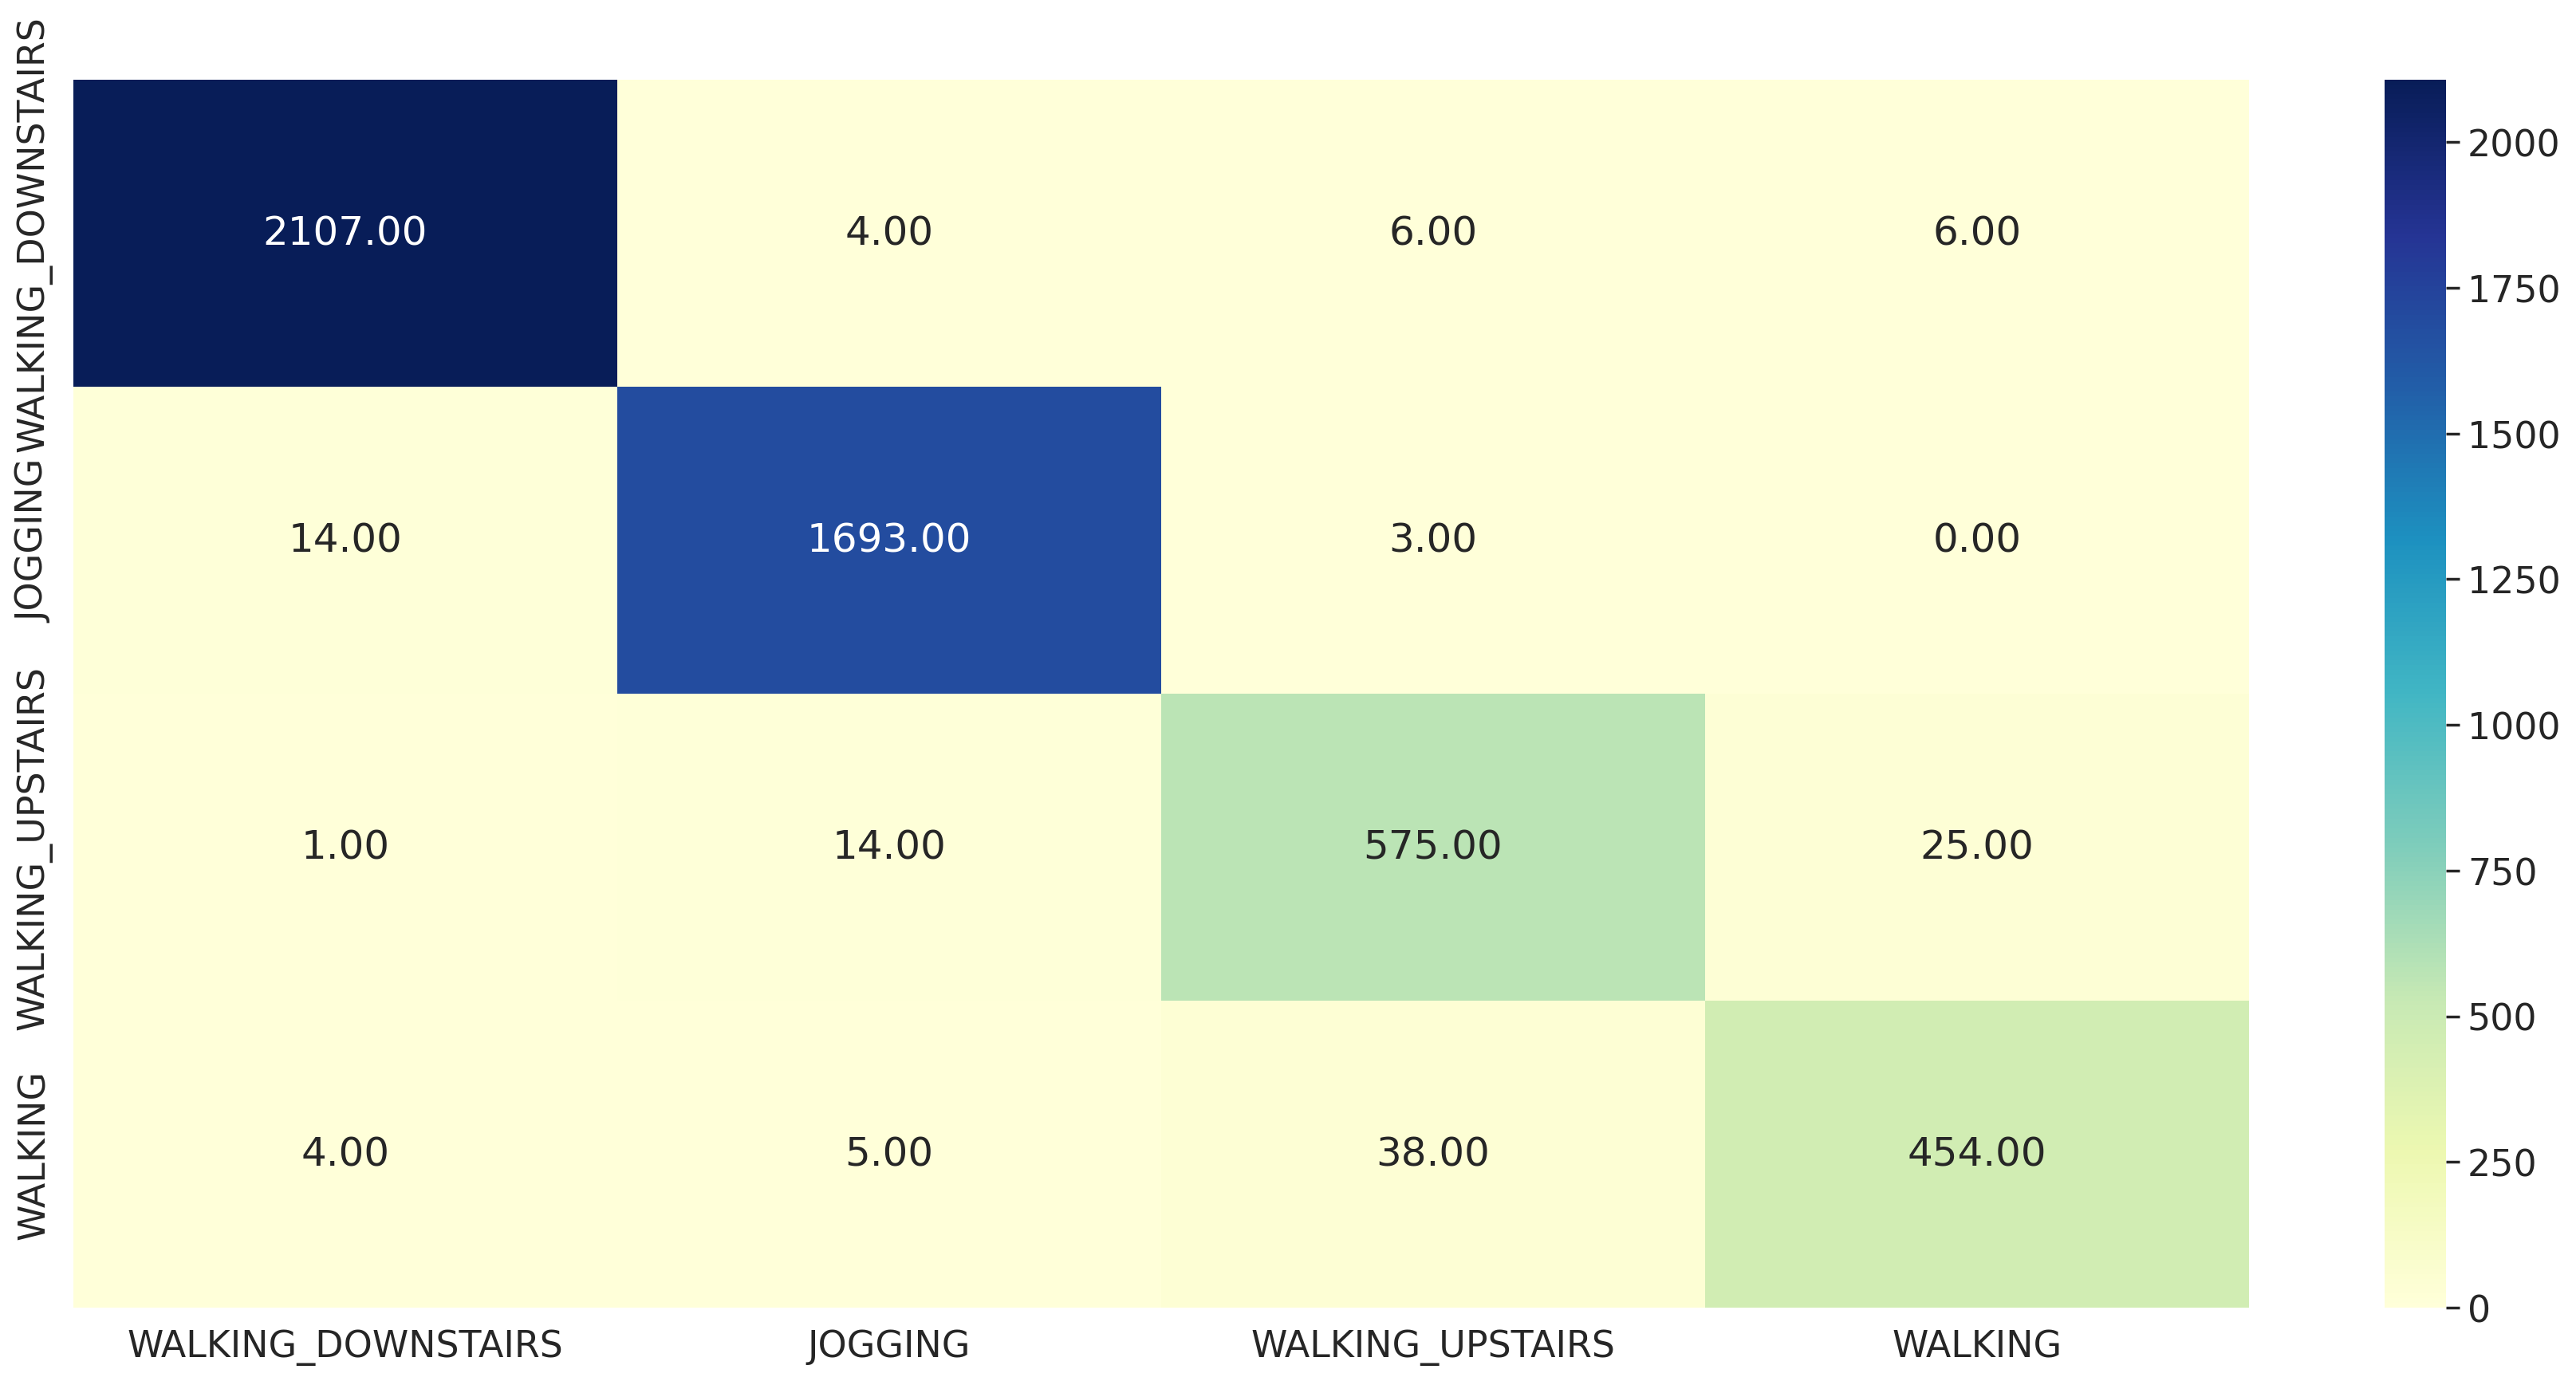

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 4

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_8 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_9 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 conv1d_10 (Conv1D)          (None, 192, 64)           12352     
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               1572992   
                                                                 
 dense_7 (Dense)             (None, 4)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 36s 258ms/step - loss: 0.5311 - accuracy: 0.7836 - val_loss: 0.2646 - val_accuracy: 0.8982
Epoch 2/10
124/124 [==============================] - 30s 238ms/step - loss: 0.2005 - accuracy: 0.9259 - val_loss: 0.1761 - val_accuracy: 0.9278
Epoch 3/10
124/124 [==============================] - 28s 225ms/step - loss: 0.1071 - accuracy: 0.9636 - val_loss: 0.1061 - val_accuracy: 0.9662
Epoch 4/10
124/124 [==============================] - 28s 224ms/step - loss: 0.0679 - accuracy: 0.9783 - val_loss: 0.0931 - val_accuracy: 0.9702
Epoch 5/10
124/124 [==============================] - 27s 217ms/step - loss: 0.0419 - accuracy: 0.9873 - val_loss: 0.1298 - val_accuracy: 0.9581
Epoch 6/10
124/124 [==============================] - 27s 217ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0857 - val_accuracy: 0.9735
Epoch 7/10
124/124 [==============================] - 27s 221ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0872 - val_ac

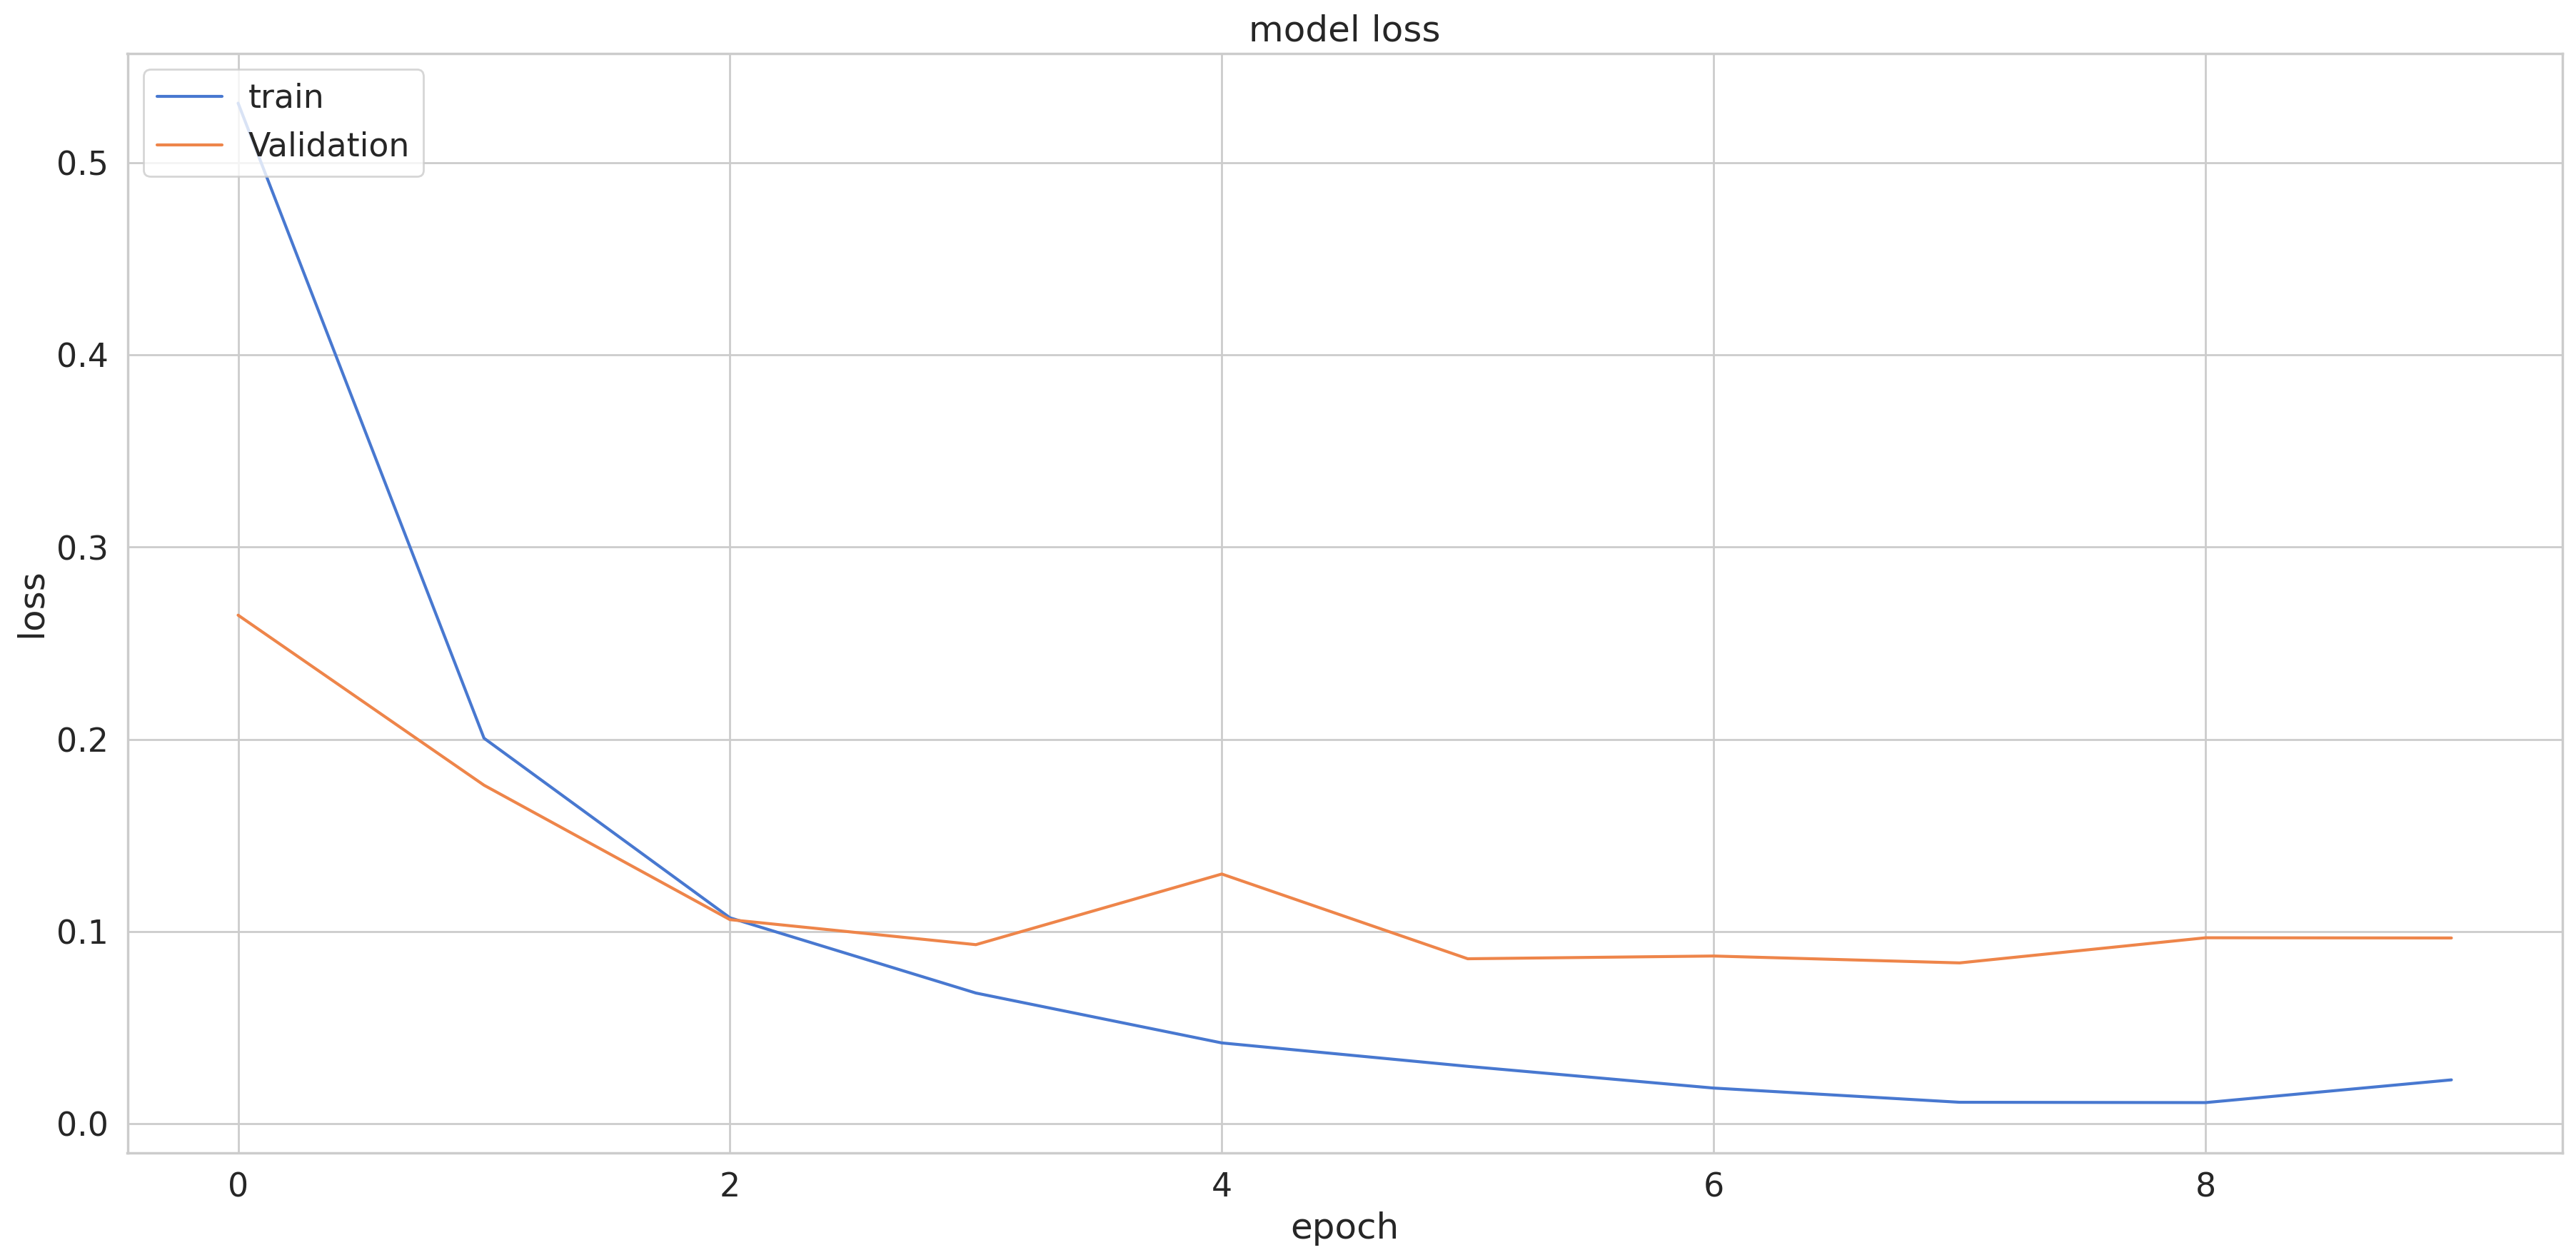

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

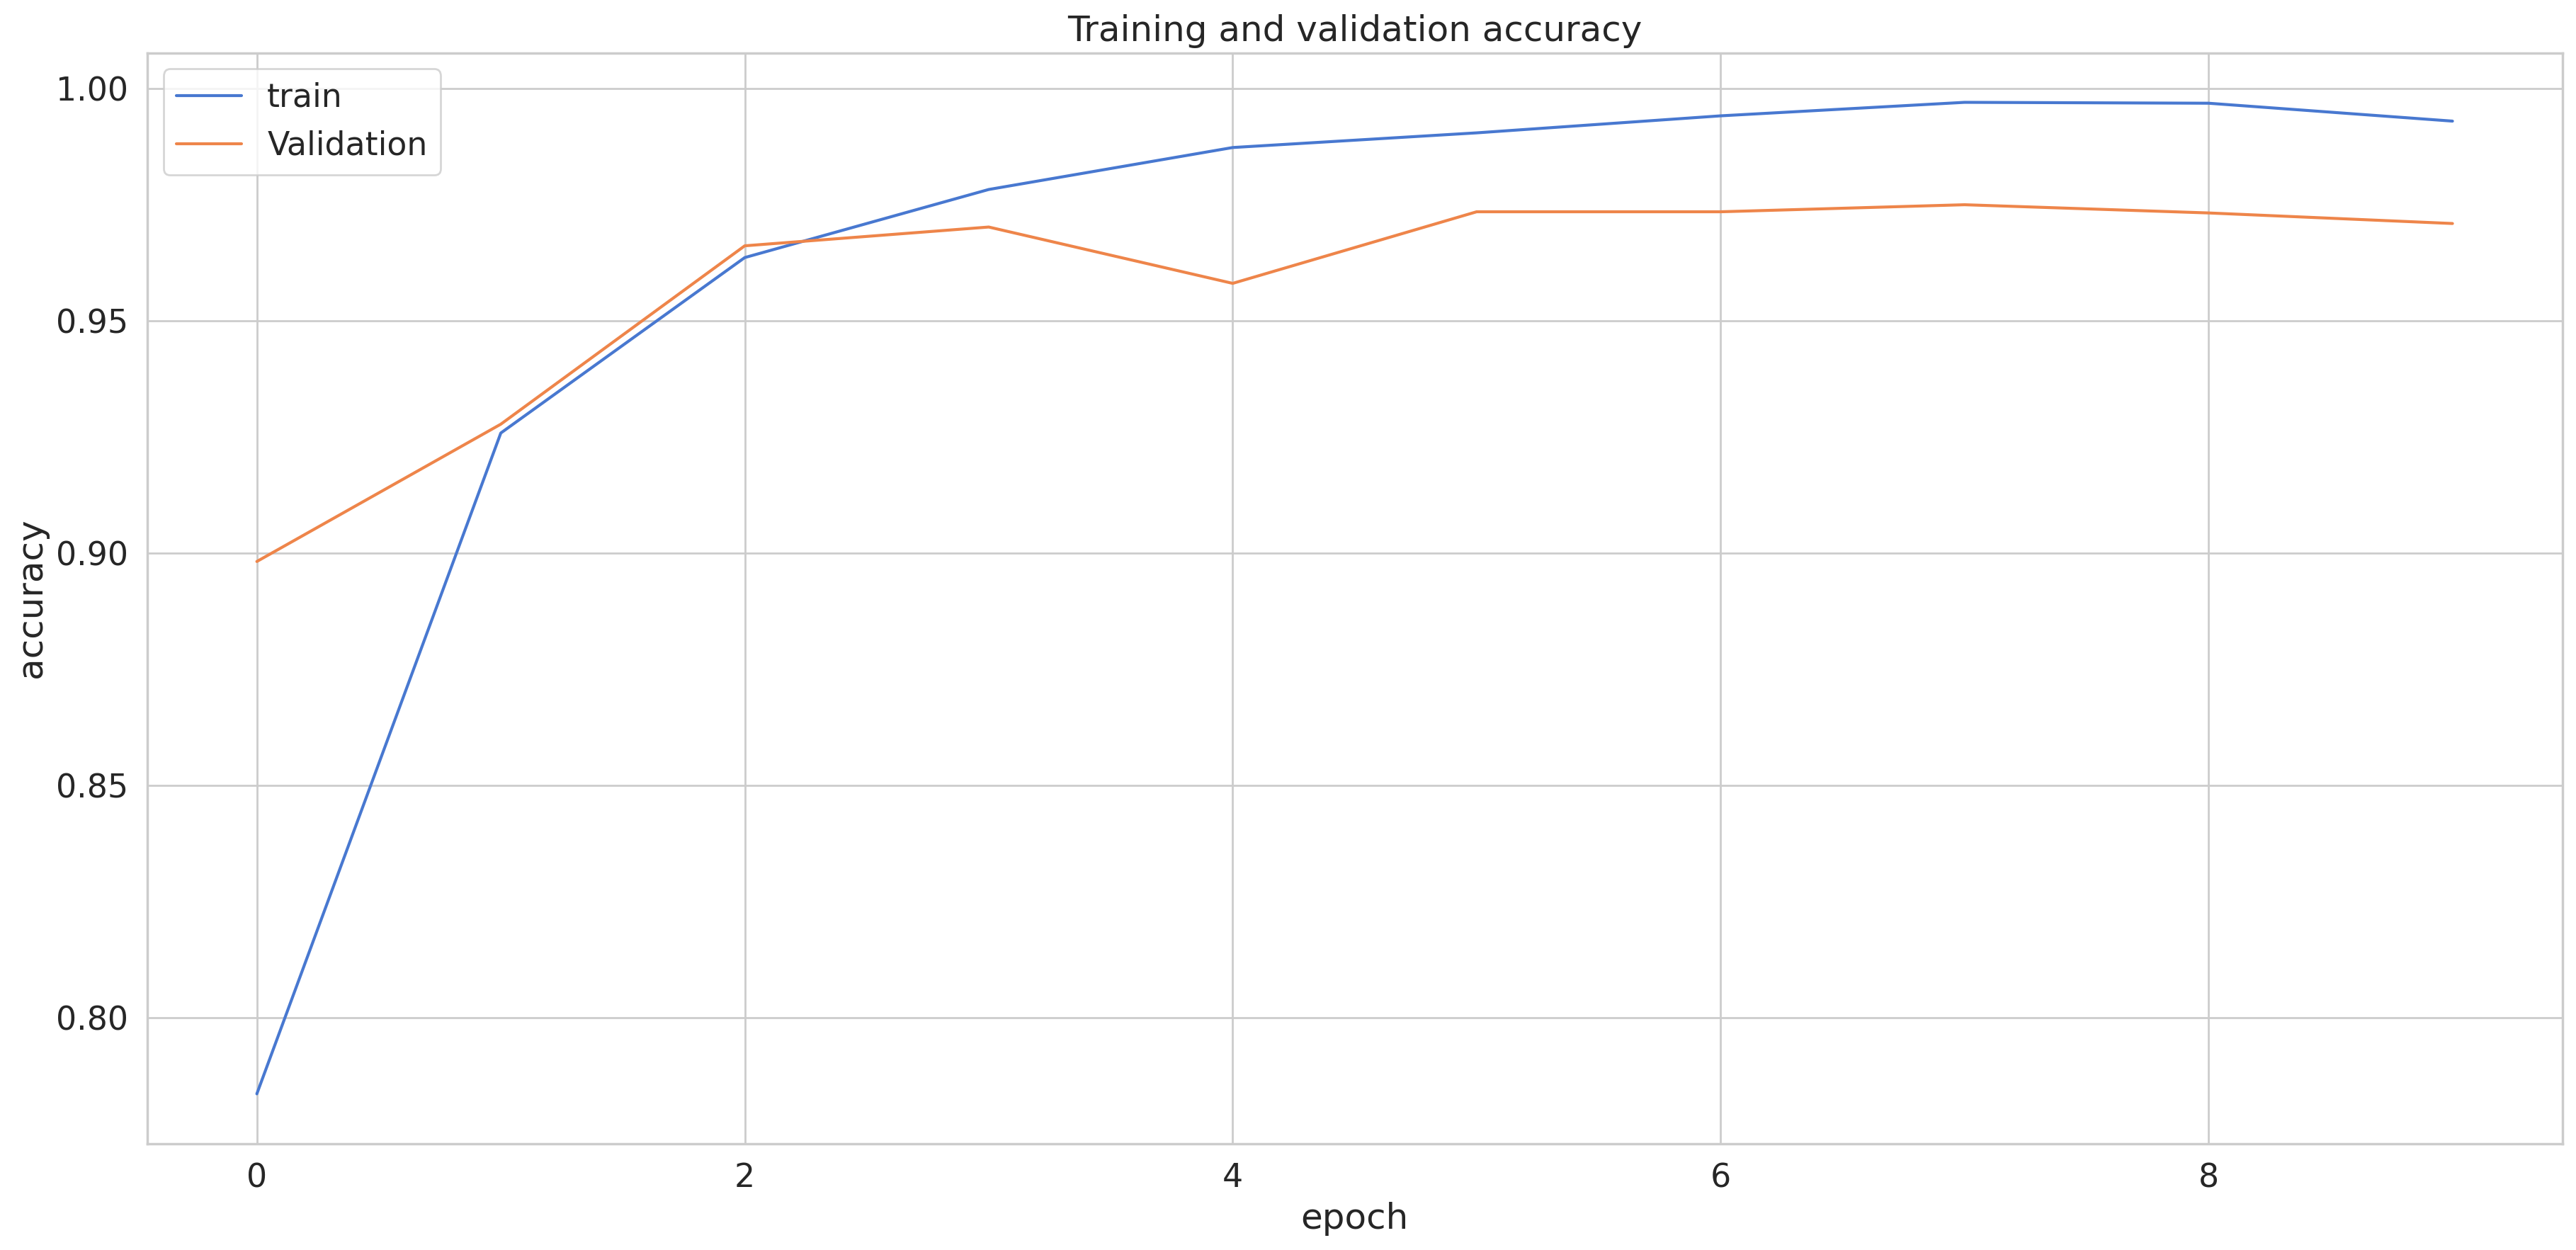

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 3s 19ms/step
f1_score =  0.9744580217189539
0.9745403111739745
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.98      0.99      0.98      1710
           2       0.96      0.90      0.93       615
           3       0.90      0.95      0.93       501

    accuracy                           0.97      4949
   macro avg       0.96      0.96      0.96      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

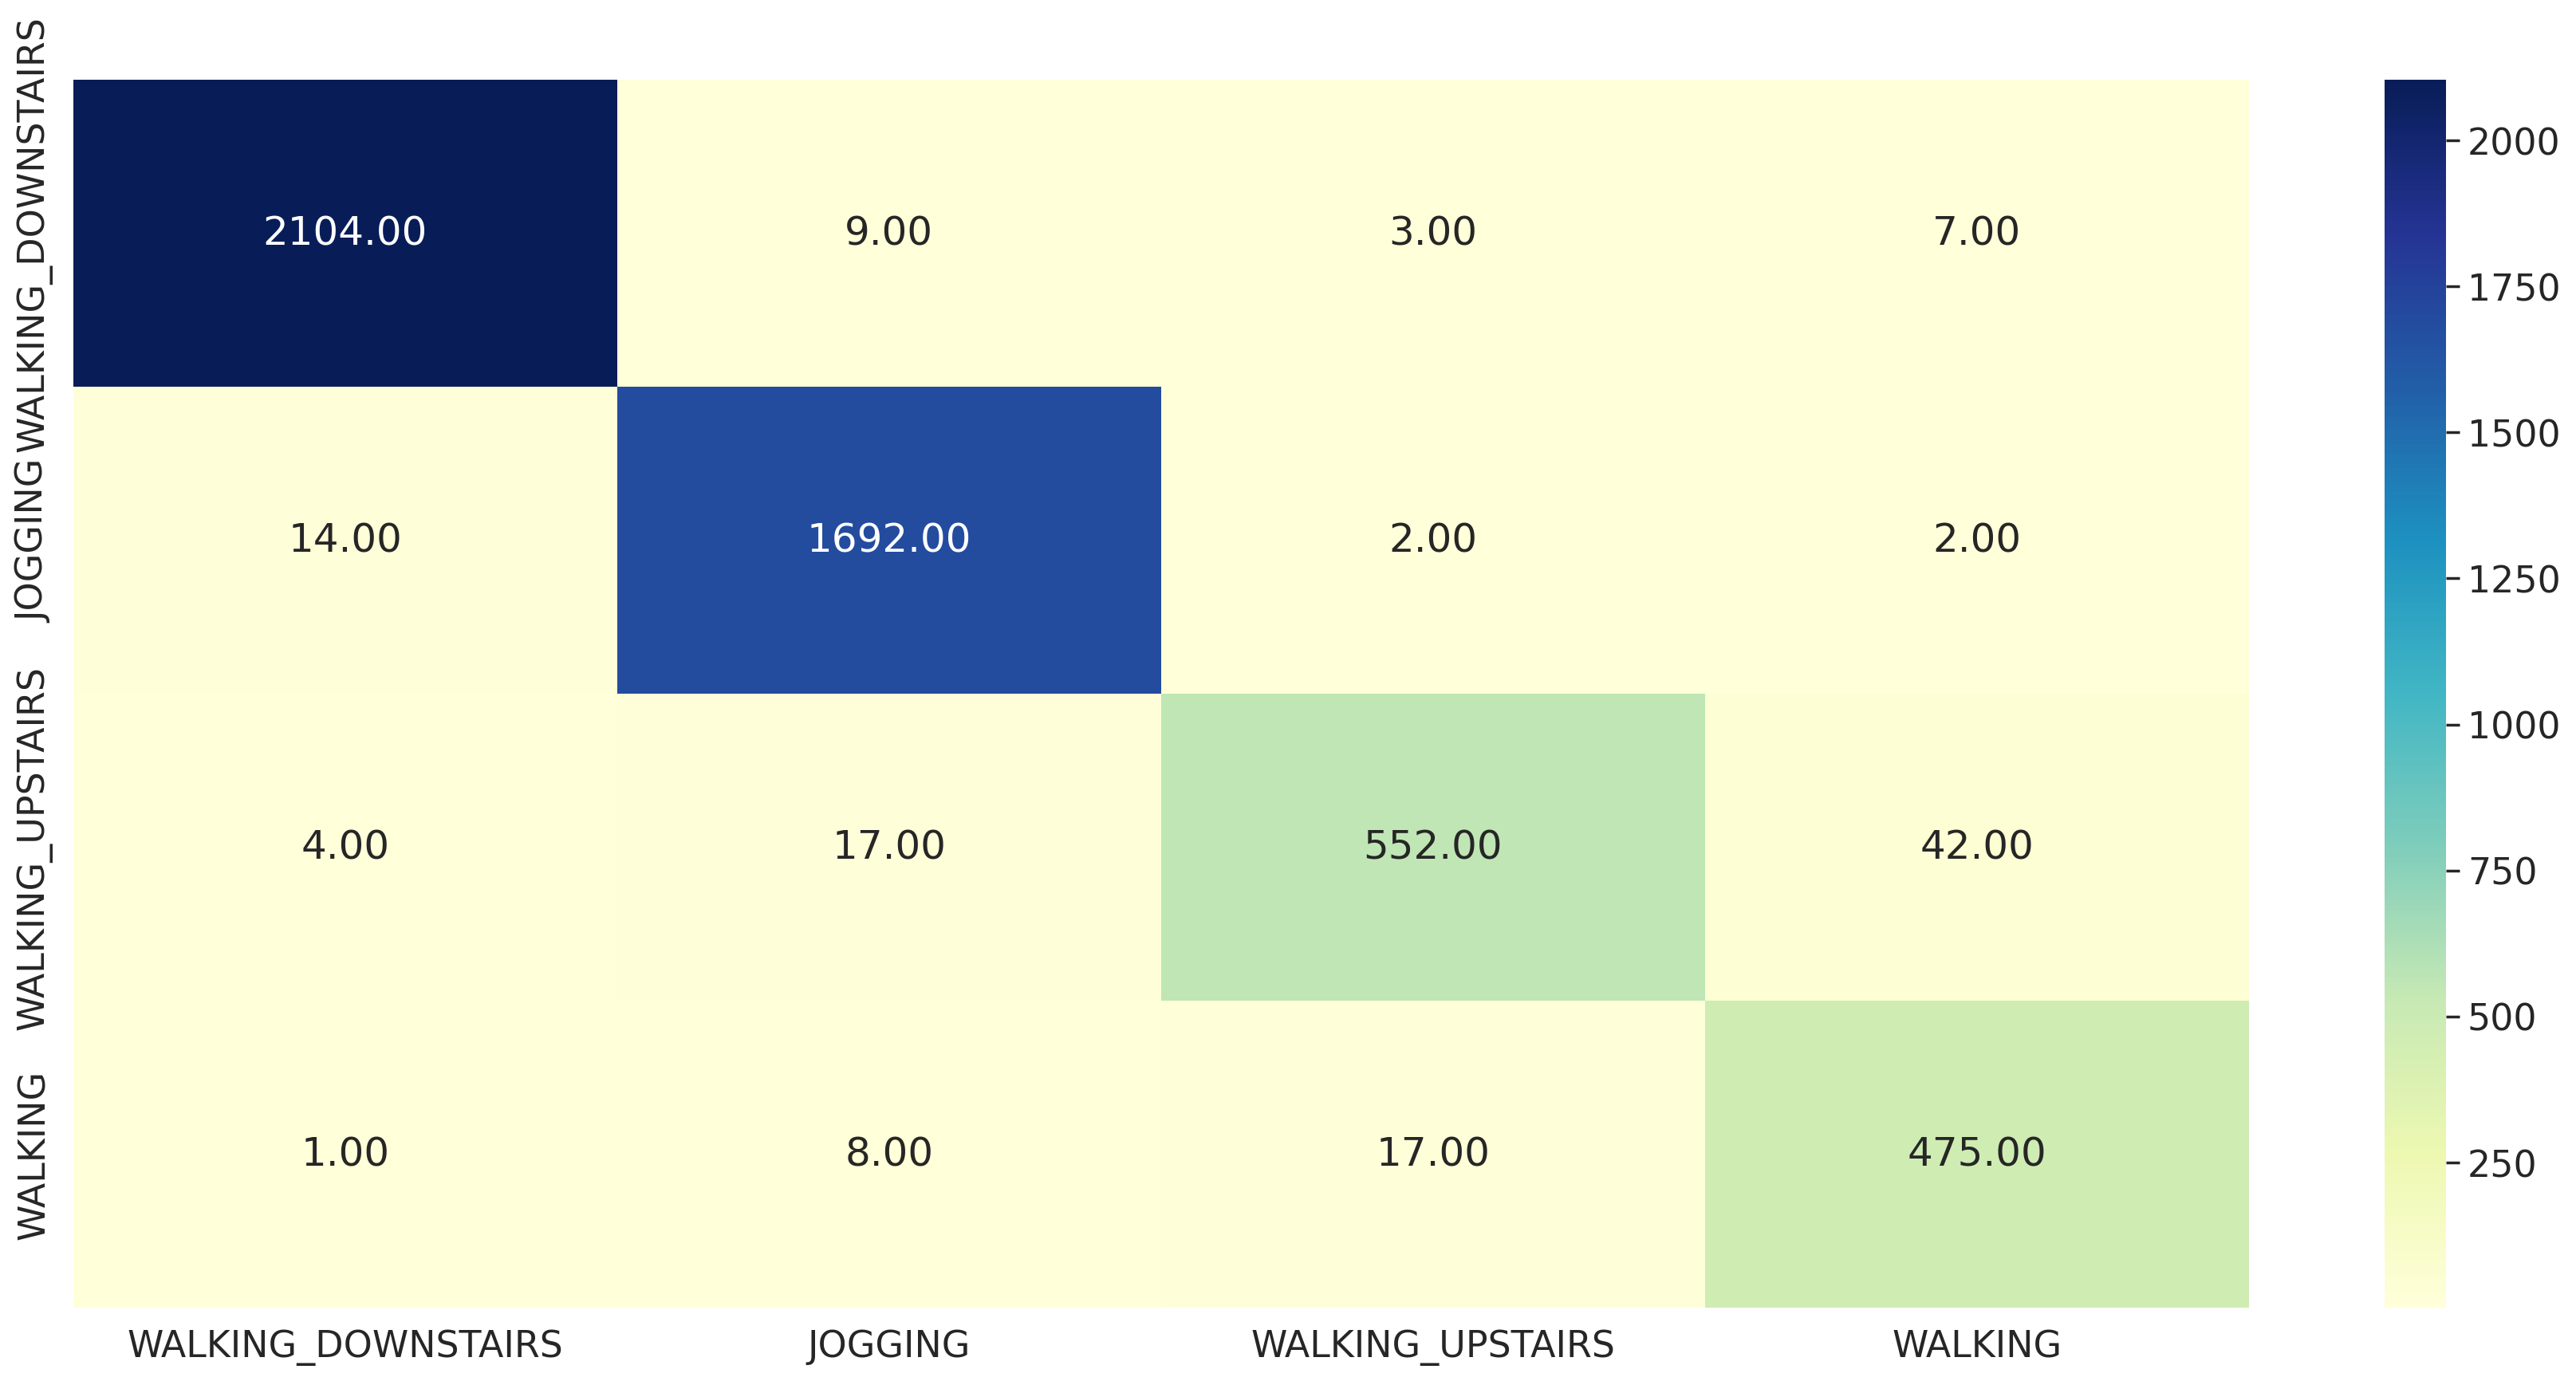

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN5

In [16]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 192, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 190, 64)           12352     
                                                                 
 flatten (Flatten)           (None, 12160)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 41s 313ms/step - loss: 0.5257 - accuracy: 0.7803 - val_loss: 0.2823 - val_accuracy: 0.8843
Epoch 2/10
124/124 [==============================] - 37s 301ms/step - loss: 0.2055 - accuracy: 0.9230 - val_loss: 0.1364 - val_accuracy: 0.9500
Epoch 3/10
124/124 [==============================] - 39s 314ms/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 0.0989 - val_accuracy: 0.9662
Epoch 4/10
124/124 [==============================] - 41s 327ms/step - loss: 0.0643 - accuracy: 0.9780 - val_loss: 0.0756 - val_accuracy: 0.9765
Epoch 5/10
124/124 [==============================] - 38s 305ms/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0764 - val_accuracy: 0.9780
Epoch 6/10
124/124 [==============================] - 37s 299ms/step - loss: 0.0374 - accuracy: 0.9872 - val_loss: 0.0742 - val_accuracy: 0.9768
Epoch 7/10
124/124 [==============================] - 41s 332ms/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0696 - val_ac

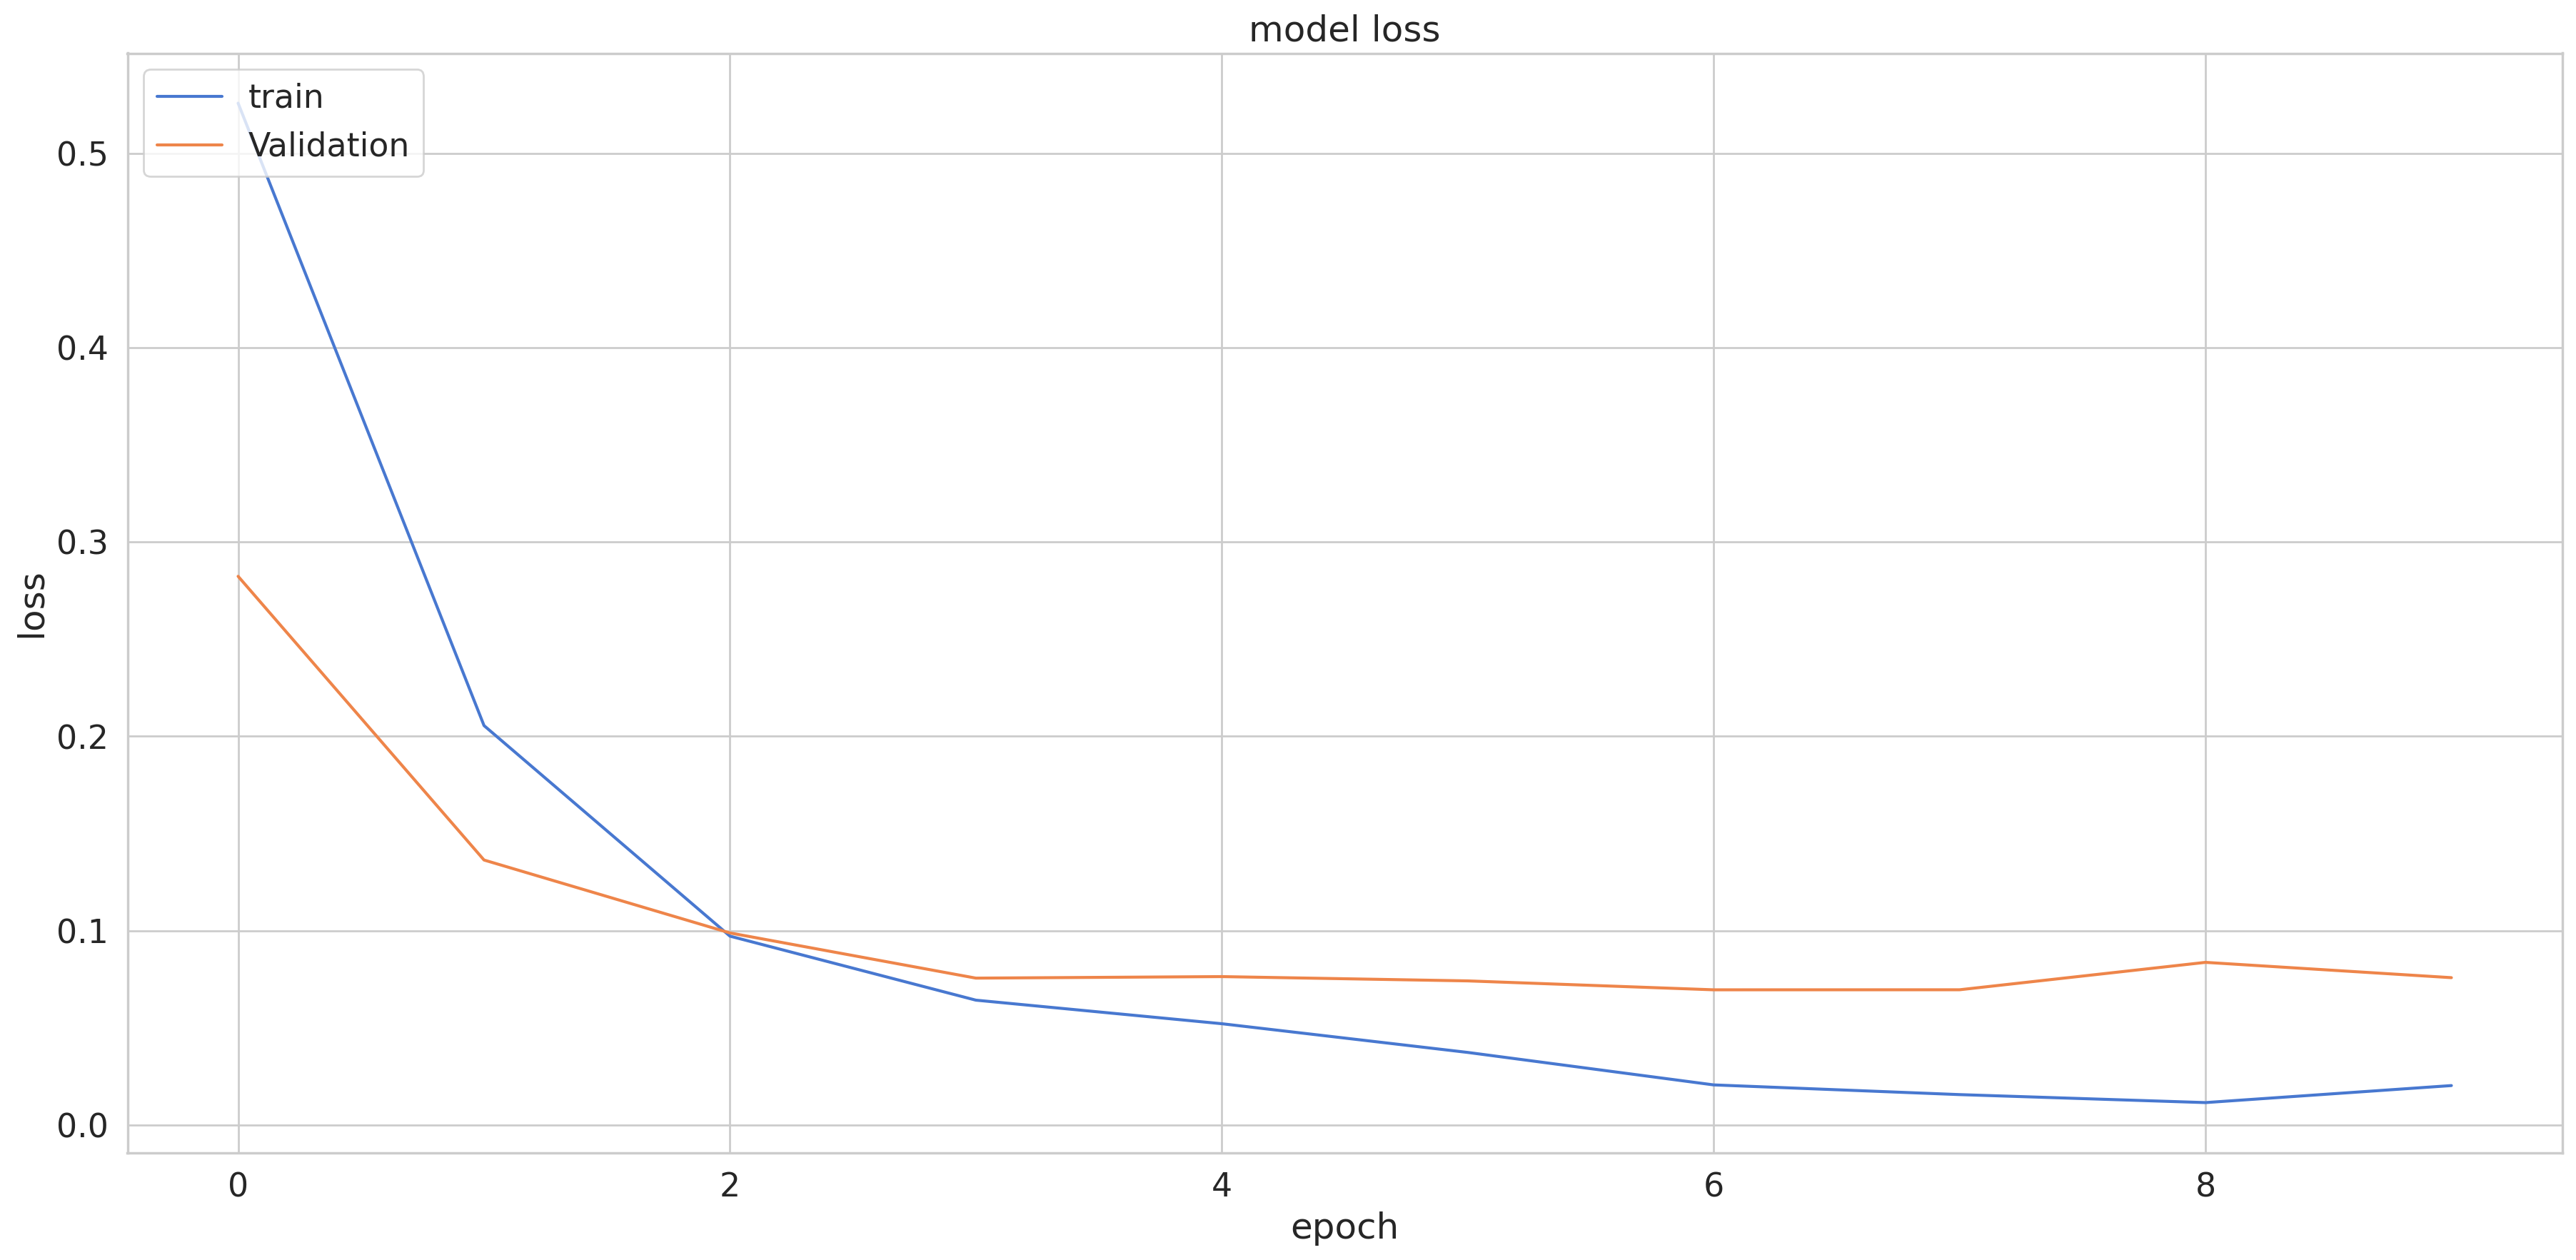

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

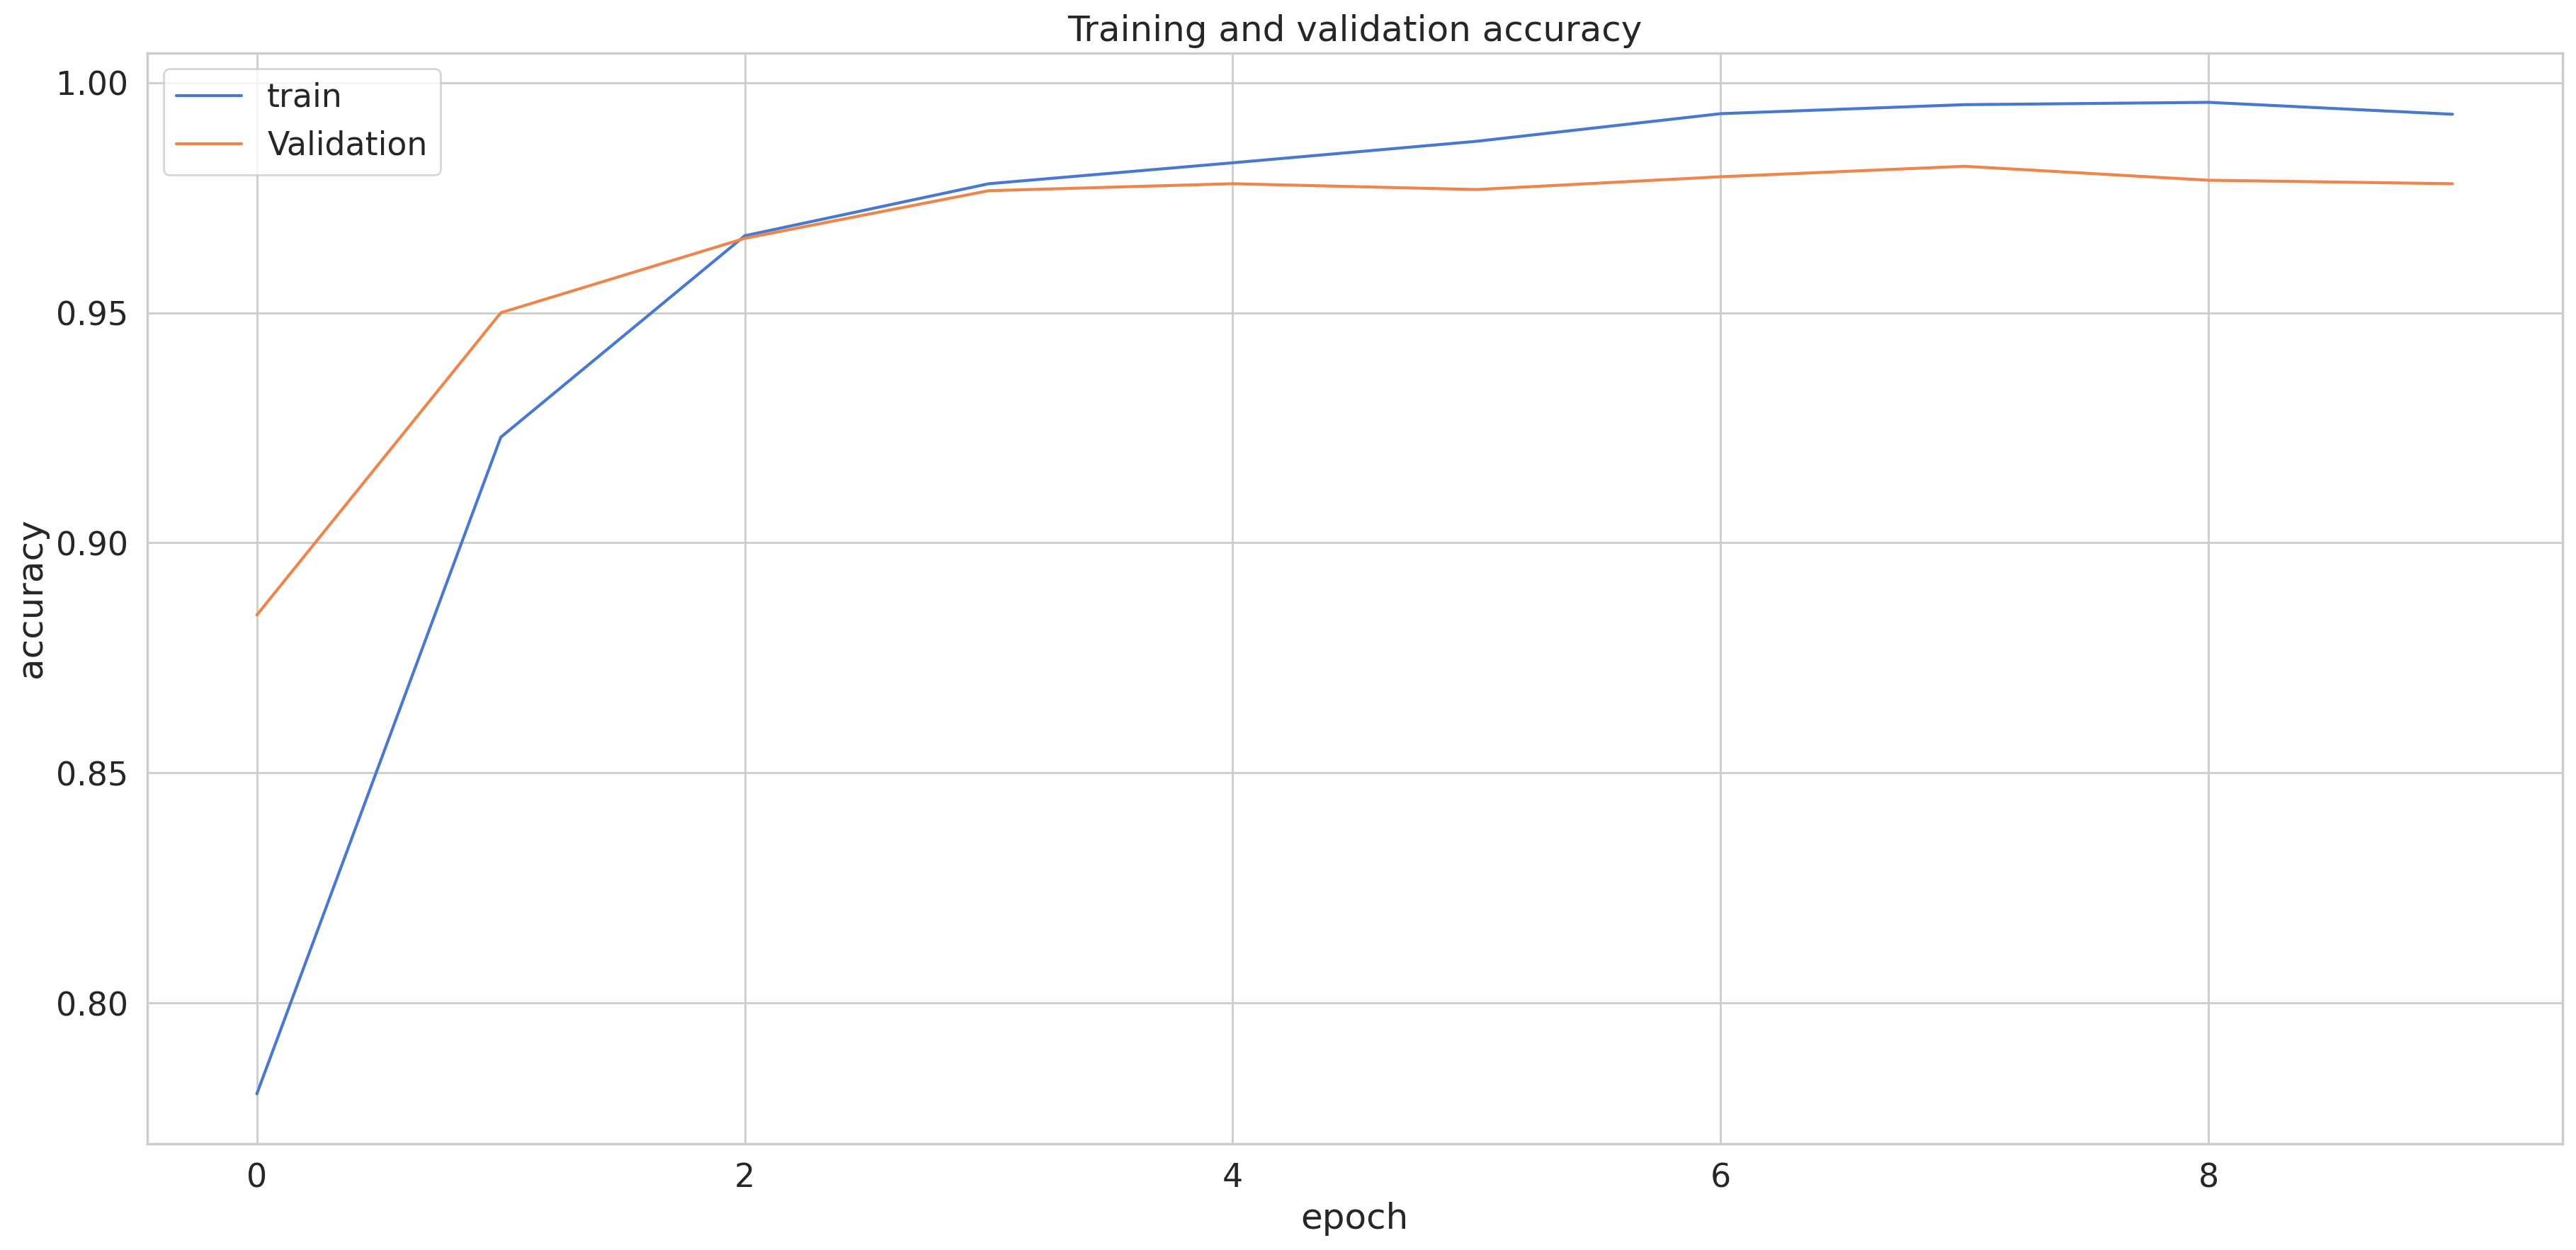

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 3s 18ms/step
f1_score =  0.9757767543969292
0.9759547383309759
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       1.00      0.99      0.99      1710
           2       0.91      0.98      0.94       615
           3       0.96      0.86      0.91       501

    accuracy                           0.98      4949
   macro avg       0.96      0.95      0.96      4949
weighted avg       0.98      0.98      0.98      4949



<Axes: >

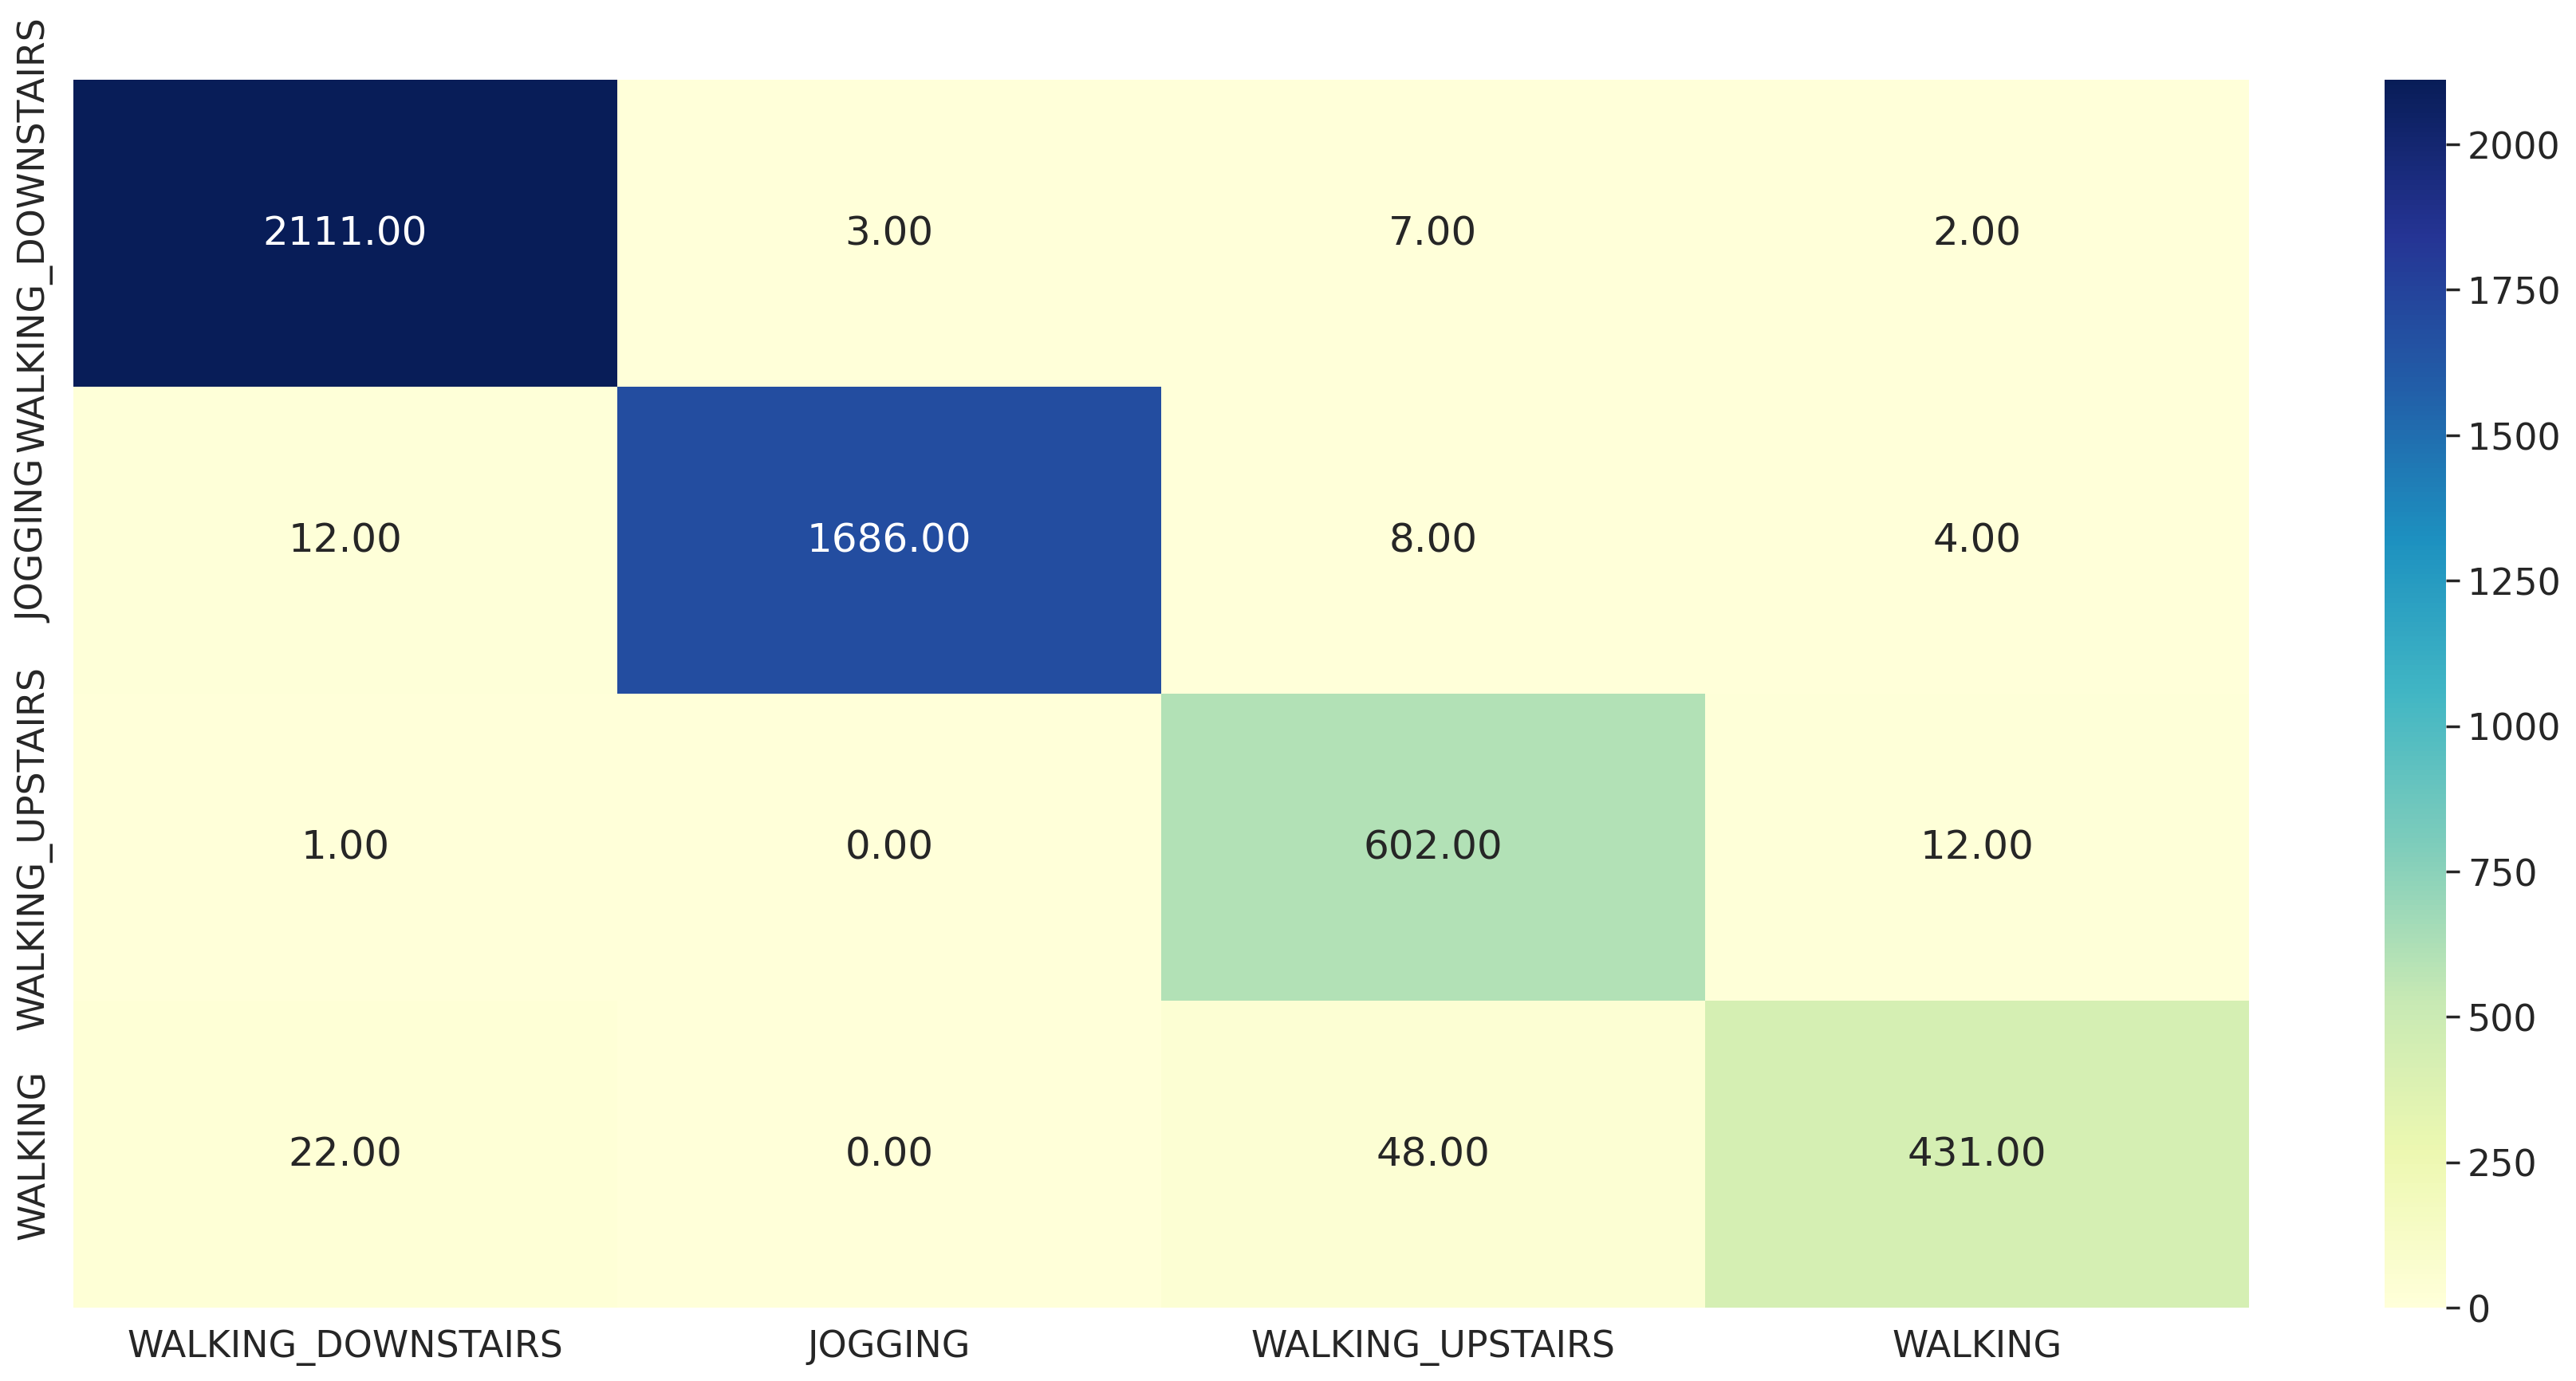

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')